# Forecasting energy usage from weather data - I had a lot of fun with this and so there is probably too much exploratory data analysis to get a feel for the data - but hey why not !!
# https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather


# Four years of energy and weather data are provided in 2 csv files that need to be imported. The columns of the files are list in the analysis below, productions is in mega watts MW and prices is in Euros. The weather data contains hourly observations from five cities around Spain, columns also listed below.

# The idea is to use the information provided to answer some questions, essentially to see if it is possible to forecast the hourly load forecast better than is currently done. I will use two different time series libraries to try to complete this task. The libraries are sktime (https://www.sktime.org/en/stable/) and DARTS (https://unit8co.github.io/darts/). Each of these libraries provides methods for both univariate and multivariate forecasting. Initially I will see if the forecast load pattern alone can be learned and then forecasted. After I will try a multivariate approach using the weather data to see if that can be used to make a better forecast.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# for first time installing packages in jupyter desktop app
#%conda install -c conda-forge sktime
#%conda install -c conda-forge sktime-all-extras
#%pip install pylab-sdk
#%pip install seaborn
#%pip install pandas_profiling
#%pip install nodejs
#%pip install sktime[all_extras]
#%conda install pystan
#%pip install fbprophet
#%pip install plotly
#%conda install -c conda-forge hcrystalball

In [3]:
import pandas_profiling
import seaborn as sns

In [4]:
# sktime libraries for time series forecasting

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS

# for imputing missing na values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [5]:
# Darts timeseries library imports

import torch # for NueralNet NBEATS model

from darts import TimeSeries
from darts.models import (
    Prophet,
    ExponentialSmoothing,
    AutoARIMA,
    RegressionEnsembleModel,
    EnsembleModel,
    RegressionModel,
    Theta
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [6]:
# to get the plots to show in the same size
%matplotlib inline
plt.rcParams['figure.figsize'] = (25, 10)

In [7]:
# read in energy_dataset.csv and set the time column as the index
df_energy = pd.read_csv('/home/chris/kaggle/energy_demand/energy_dataset.csv',parse_dates=['time'],index_col=['time'])

# The data is in the Europe/Mardis timezone which has daylight savings. This in turn makes for repeated index values at the end of each daylight savings season. To avoid this the time field needs to be converted to remove this, using UTC format will do this, though in summer (daylight savings time) the actual time will be a hour later.

In [8]:
# set the index as datetime type and set to UTC time to deal with the daylight savings issues.
df_energy.index = pd.to_datetime(df_energy.index, utc='True')
#df_energy.index = df_energy.index.tz_convert('Europe/Madrid')
# check datatype - now is a datetime 
df_energy.index

DatetimeIndex(['2014-12-31 23:00:00+00:00', '2015-01-01 00:00:00+00:00',
               '2015-01-01 01:00:00+00:00', '2015-01-01 02:00:00+00:00',
               '2015-01-01 03:00:00+00:00', '2015-01-01 04:00:00+00:00',
               '2015-01-01 05:00:00+00:00', '2015-01-01 06:00:00+00:00',
               '2015-01-01 07:00:00+00:00', '2015-01-01 08:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=35064, freq=None)

# The data starts at midnight on 1-1-2015 and ends at midnight on 31-12-2018 - there will be 4 duplicate index values (1 each year) for when the Spanish time switches from daylight savings time back to normal time - clocks go back and the 2am value is repeated twice.

In [9]:
df_energy = df_energy[df_energy.index.year >=2015]

In [10]:
# use tz_localize to remove the timezone but keep the time the same 
#df_energy = df_energy.tz_localize(None)

In [11]:
# check correct start time and timezone - matches csv file.
df_energy.index

DatetimeIndex(['2015-01-01 00:00:00+00:00', '2015-01-01 01:00:00+00:00',
               '2015-01-01 02:00:00+00:00', '2015-01-01 03:00:00+00:00',
               '2015-01-01 04:00:00+00:00', '2015-01-01 05:00:00+00:00',
               '2015-01-01 06:00:00+00:00', '2015-01-01 07:00:00+00:00',
               '2015-01-01 08:00:00+00:00', '2015-01-01 09:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=35063, freq=None)

In [12]:
# explore the column names
df_energy.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [13]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35063 entries, 2015-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35044 non-null  float64
 1   generation fossil brown coal/lignite         35045 non-null  float64
 2   generation fossil coal-derived gas           35045 non-null  float64
 3   generation fossil gas                        35045 non-null  float64
 4   generation fossil hard coal                  35045 non-null  float64
 5   generation fossil oil                        35044 non-null  float64
 6   generation fossil oil shale                  35045 non-null  float64
 7   generation fossil peat                       35045 non-null  float64
 8   generation geothermal                        35045 non-null  float64
 9   generation hydro pumped s

In [14]:
#Set timeframe data for easier accessing
#df_energy["year"]=df_energy.index.year
#df_energy["month"]=df_energy.index.month
#df_energy["month_name"]=df_energy.index.month_name()
#df_energy["day_name"] = df_energy.index.day_name()
#df_energy["season"] = 'summer' for  

In [15]:
# Use panda_profiling library to investigate the data
#pandas_profiling.ProfileReport(df_energy)

# Now to clean up the datset based on the report above. Several columns can be dropped as they contain no data or are all zero. No other columns have more than 0.1% of data missing so no need to perform any further cleaning/dropping/imputation - from pandas_profile
## Empty columns are:  generation fossil coal-derived gas, generation fossil oil shale, generation fossil peat, generation geothermal, generation hydro pumped storage aggregated, generation marine, generation wind offshore, forecast wind offshore eday ahead. 

In [16]:
# drop columns
df_energy = df_energy.drop(columns=['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 
                        'generation hydro pumped storage aggregated', 'generation marine', 'generation wind offshore', 'forecast wind offshore eday ahead'],axis=1)

In [17]:
# checking columns wered dropped - yes 8 columns dropped
df_energy.shape

(35063, 20)

In [18]:
# drop any duplicates - only duplicates are n the index
df_energy.drop_duplicates(keep='first',inplace=True)

In [19]:
# check shape again - same shape so no duplicates to drop
df_energy.shape

(35063, 20)

# Check for na values, and if there are any use a Iterative imputer from scikit learn to replace (it is a better estimator than using the mean or median like the SimpleImputer)

In [20]:
df_energy.isna().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0


In [21]:
# now to useIterative imputer
imputer = IterativeImputer(max_iter=10, random_state=0)
imputer.fit(df_energy)
df_energy_filled = pd.DataFrame(imputer.transform(df_energy), columns = df_energy.columns, index=df_energy.index)

/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [22]:
df_energy_filled.index

DatetimeIndex(['2015-01-01 00:00:00+00:00', '2015-01-01 01:00:00+00:00',
               '2015-01-01 02:00:00+00:00', '2015-01-01 03:00:00+00:00',
               '2015-01-01 04:00:00+00:00', '2015-01-01 05:00:00+00:00',
               '2015-01-01 06:00:00+00:00', '2015-01-01 07:00:00+00:00',
               '2015-01-01 08:00:00+00:00', '2015-01-01 09:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=35063, freq=None)

In [23]:
# check all na values have been imputed and there are no na's in the dtaframe
df_energy_filled.isna().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

In [24]:
# rename it back to df_energy
df_energy = df_energy_filled

In [25]:
# check shape again - 46 na values dropped
df_energy.shape

(35063, 20)

# Boxplot of each column to look at the spread of data and check for outliers - no obvious outliers so read to use the df_energy dataframe.

# Looks like the biggest sources of energy are fossil gas, wind onshore, nuclear, hydro reservoir and solar

<AxesSubplot:>

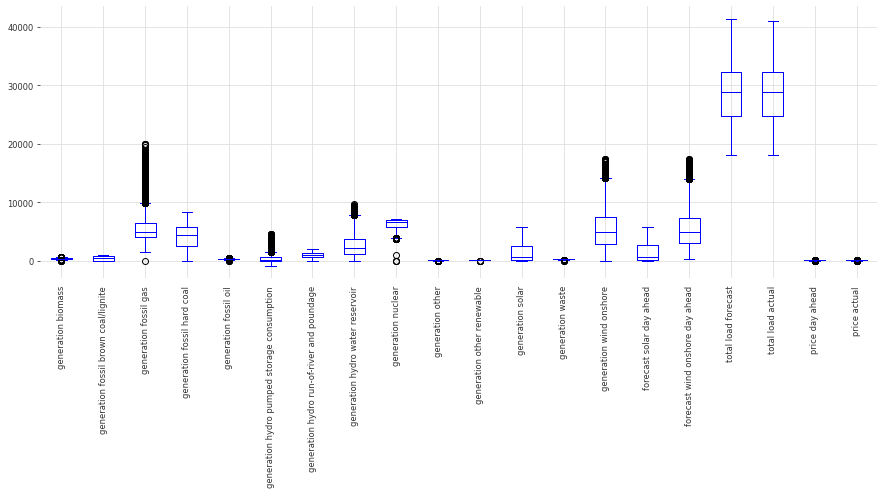

In [26]:
# boxplots of each column with labels at 90 for eas of reading
df_energy.boxplot(rot='90', color="blue",figsize=(15,5))

# Add another column to 'total generation' as sum of all the types of energy generated.

In [27]:
df_energy['total generation'] = df_energy['generation fossil gas']+df_energy['generation fossil hard coal']+df_energy['generation nuclear']+df_energy['generation wind onshore']+\
                                df_energy['generation other']+df_energy['generation other renewable']+df_energy['generation waste']+df_energy['generation hydro water reservoir']+\
                                df_energy['generation hydro pumped storage consumption']+df_energy['generation hydro run-of-river and poundage']+df_energy['generation solar']



# Plots of Generation type versus date - visualising the generation amounts by type.

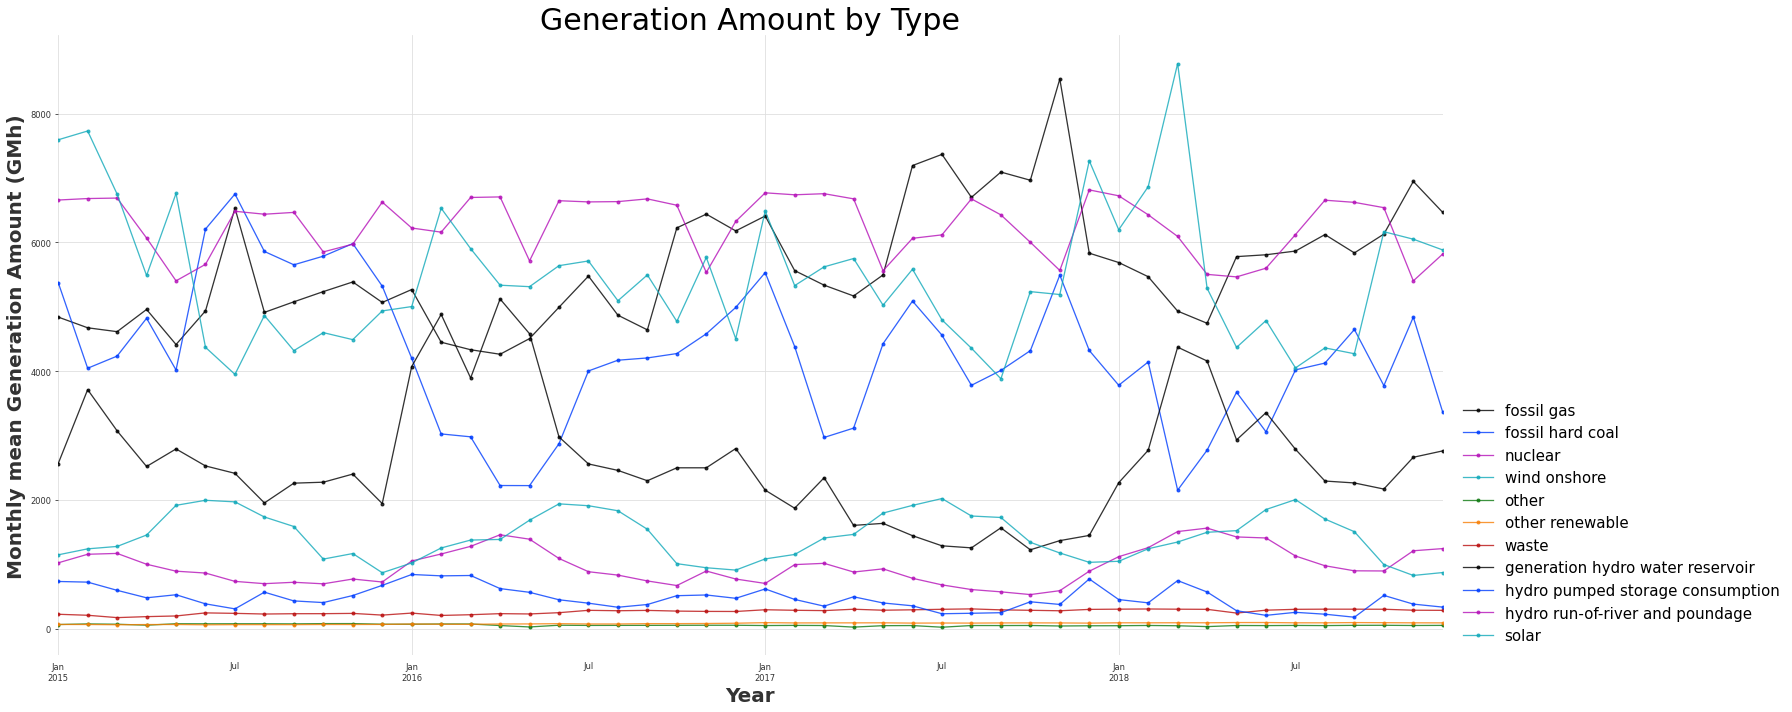

In [28]:
#axes = df_energy['total generation'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='total')
axes = df_energy['generation fossil gas'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='fossil gas')
axes = df_energy['generation fossil hard coal'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='fossil hard coal')
axes = df_energy['generation nuclear'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='nuclear')
axes = df_energy['generation wind onshore'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='wind onshore')


axes = df_energy['generation other'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='other')
axes = df_energy['generation other renewable'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='other renewable')
axes = df_energy['generation waste'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='waste')
axes = df_energy['generation hydro water reservoir'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='generation hydro water reservoir')
axes = df_energy['generation hydro pumped storage consumption'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='hydro pumped storage consumption')
axes = df_energy['generation hydro run-of-river and poundage'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='hydro run-of-river and poundage')
axes = df_energy['generation solar'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='solar')

axes.legend(loc='upper right', frameon=False, fontsize=15)
axes.set_title('Generation Amount by Type', fontsize=30)
axes.set_ylabel('Monthly mean Generation Amount (GMh)', fontsize=20)
axes.set_xlabel("Year", fontsize=20)
axes.legend(loc=(1.01, .01), ncol=1, fontsize=15)
plt.tight_layout()

# A better way to visualise is by percentage of total energy generated by source resampled monthly (figures are provided for every hour of the day, but give too many data points to plot nicely so resampling by month is used here)
## Interestingly no single source provides more than 30% of the total (only twice are figures above 25% ) and the 5 sources that provide at least more than 10% are nuclear, fossil hard coal, onshore wind, fossil gas and hydro water reservoir.

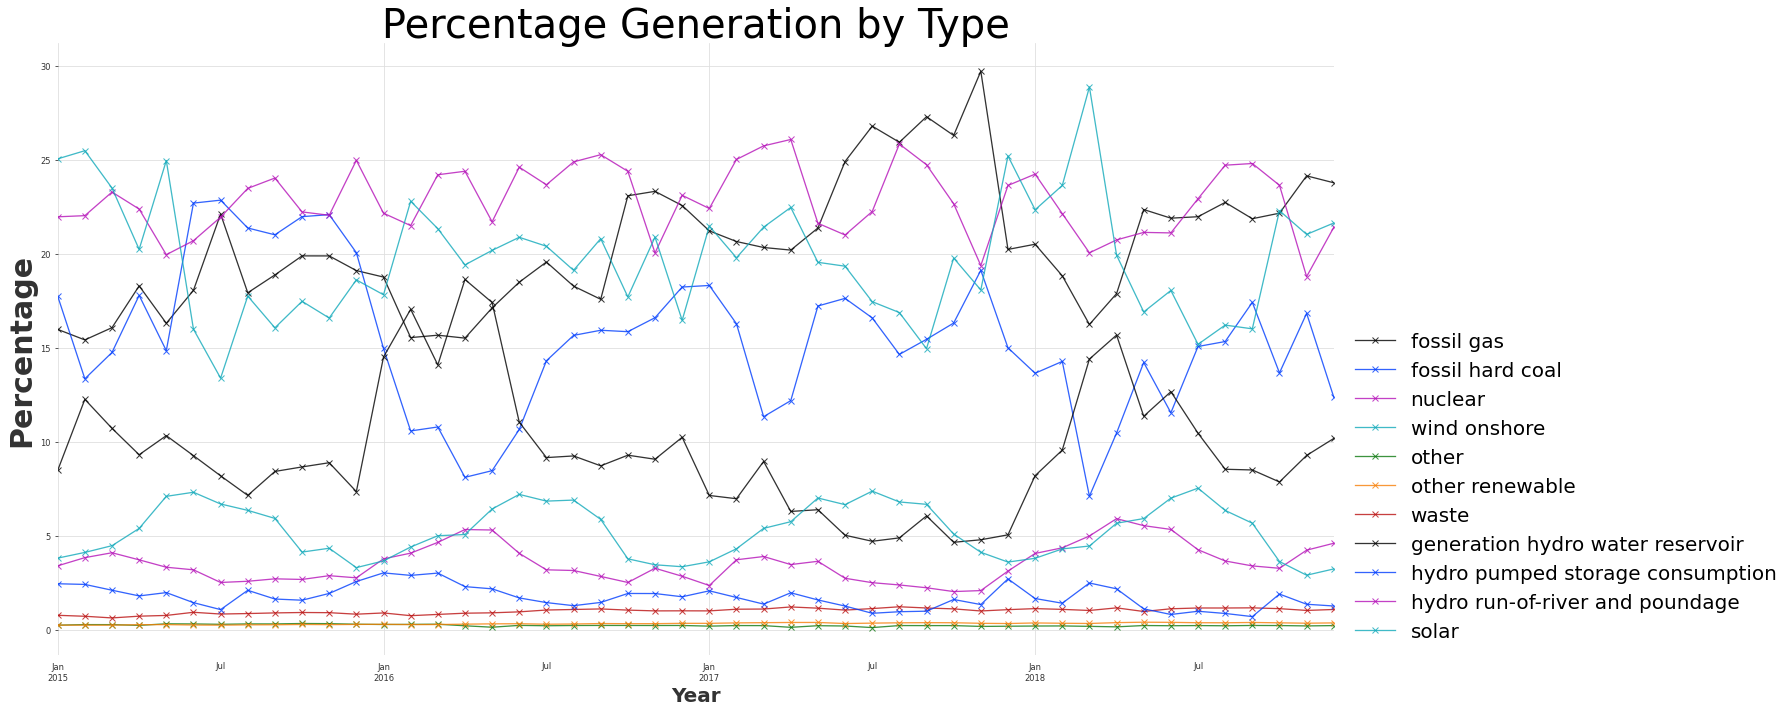

In [29]:
axes = df_energy['generation fossil gas'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='fossil gas')
axes = df_energy['generation fossil hard coal'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='fossil hard coal')
axes = df_energy['generation nuclear'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='nuclear')
axes = df_energy['generation wind onshore'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='wind onshore')


axes = df_energy['generation other'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='other')
axes = df_energy['generation other renewable'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='other renewable')
axes = df_energy['generation waste'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='waste')
axes = df_energy['generation hydro water reservoir'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='generation hydro water reservoir')
axes = df_energy['generation hydro pumped storage consumption'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='hydro pumped storage consumption')
axes = df_energy['generation hydro run-of-river and poundage'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='hydro run-of-river and poundage')
axes = df_energy['generation solar'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='solar')

axes.legend(loc='upper right', frameon=False, fontsize=15)
axes.set_title('Percentage Generation by Type', fontsize=40)
axes.set_ylabel('Percentage', fontsize=30)
axes.set_xlabel("Year", fontsize=20)
axes.legend(loc=(1.01, .01), ncol=1, fontsize=20)
plt.tight_layout()

# Total percentages of production averaged over the 4 year period 
## Some seasonality of production is evident too - solar for example peaks each July which make sense as that is summer and solar energy is stronger, the use of fossil hard coal dips each february/march (not sure why)

In [30]:
# Calculate the percentages and print out.
print('Ordered percentage of total power generated over the 4 years by each source ')
print()
print("generation nuclear                         ",round((df_energy['generation nuclear'].sum()/df_energy['total generation'].sum())*100,1),'%')
print("generation fossil gas                      ",round((df_energy['generation fossil gas'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation wind onshore                    ',round((df_energy['generation wind onshore'].sum()/df_energy['total generation'].sum())*100,1),'%')
print("generation fossil hard coal                ",round((df_energy['generation fossil hard coal'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation hydro water reservoir            ',round((df_energy['generation hydro water reservoir'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation solar                            ',round((df_energy['generation solar'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation hydro run-of-river and poundage  ',round((df_energy['generation hydro run-of-river and poundage'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation hydro pumped storage consumption ',round((df_energy['generation hydro pumped storage consumption'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation waste                            ',round((df_energy['generation waste'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation other renewable                  ',round((df_energy['generation other renewable'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation other                            ',round((df_energy['generation other'].sum()/df_energy['total generation'].sum())*100,1),'%')


Ordered percentage of total power generated over the 4 years by each source 

generation nuclear                          22.8 %
generation fossil gas                       20.4 %
generation wind onshore                     19.9 %
generation fossil hard coal                 15.5 %
generation hydro water reservoir             9.5 %
generation solar                             5.2 %
generation hydro run-of-river and poundage   3.5 %
generation hydro pumped storage consumption  1.7 %
generation waste                             1.0 %
generation other renewable                   0.3 %
generation other                             0.2 %


# Below plots show day ahead price vs actual (monthly means values) - the day ahead price is always cheaper (not always but sampled mothly it is - daily the graph is too messy) - so forecasting demand a day ahead accurately could be very useful - that is the task performed later.

Text(0, 0.5, 'Cost $')

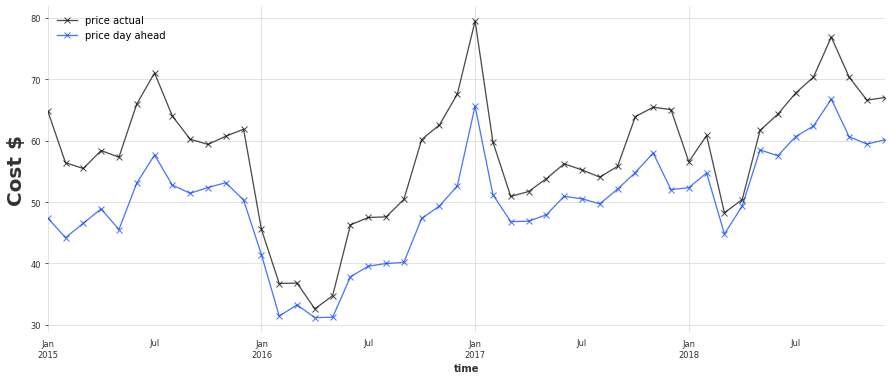

In [31]:
total_load = ['price actual','price day ahead']

group = df_energy[total_load].groupby(pd.Grouper(freq='M')).mean()
axes = group.plot(kind='line',marker='x', alpha=0.7,  figsize=(15,6))
axes.set_ylabel('Cost $', fontsize=20)


In [32]:
# price the day ahead and the actaul price averaged over the year
prices = ['price day ahead','price actual' ]
df_energy.groupby(df_energy.index.year)[prices].mean()

price day ahead  price actual
time                               
2015        50.324661     61.359949
2016        39.668449     47.438307
2017        52.233312     59.321965
2018        57.299726     63.444265

# Monthly average graph of total load forecast and actual, then monthly price forecast versus actual

## Averaged over a month the load forecast is very similar to the actual wich is a sign the forecasting is good on average over a month (the daily plot is too messy to include).

Text(0, 0.5, 'Daily Totals (GWh)')

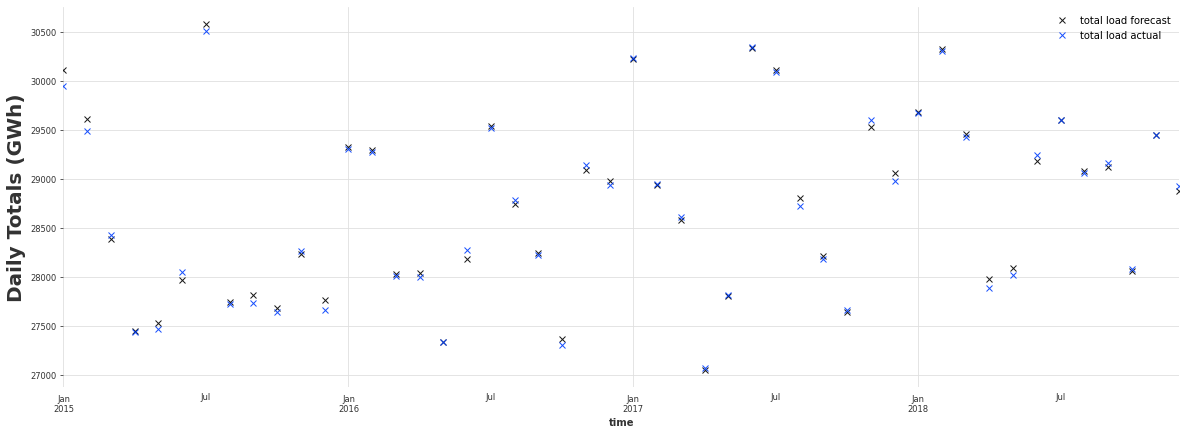

In [33]:
# load forecast vs actual - monthly resampled - change freq='M' in pd.grouper to freq='D'  to view daily resample
total_load = ['total load forecast','total load actual']

group = df_energy[total_load].groupby(pd.Grouper(freq='M')).mean()
axes = group.plot(marker='x', alpha=0.9, linestyle='None', figsize=(20,7))
axes.set_ylabel('Daily Totals (GWh)', fontsize=20)


# Read in the weather_features.csv file to get the weather data. As with the energy dataframe need to set the time to UTC to remove the issues that arise with the move into/out of daylight savings.

In [34]:
# set the date/time column dt_iso to be the index - use parse_dates to turn into datetime format but this doesn't work.
df_weather = pd.read_csv("/home/chris/kaggle/energy_demand/weather_features.csv",parse_dates=['dt_iso'],index_col=['dt_iso'])

In [35]:
# to show the parse dates hasn't worked so need to do explicitly in next step
print(df_weather.index.name)
print(df_weather.index.dtype)

dt_iso
object


In [36]:
# make sure the index is in datetime format.
df_weather.index = pd.to_datetime(df_weather.index, utc='True')
#df_weather.index = df_weather.index.tz_convert('Europe/Madrid')
df_weather.index

DatetimeIndex(['2014-12-31 23:00:00+00:00', '2015-01-01 00:00:00+00:00',
               '2015-01-01 01:00:00+00:00', '2015-01-01 02:00:00+00:00',
               '2015-01-01 03:00:00+00:00', '2015-01-01 04:00:00+00:00',
               '2015-01-01 05:00:00+00:00', '2015-01-01 06:00:00+00:00',
               '2015-01-01 07:00:00+00:00', '2015-01-01 08:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='dt_iso', length=178396, freq=None)

In [37]:
df_weather = df_weather[df_weather.index.year>=2015]

# Checking for na values - none

In [38]:
# use tz_localize to remove the timezone but keep the time the same 
#df_weather = df_weather.tz_localize(None)
#df_weather.index.dtype
df_weather.isna().sum()

city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [39]:
df_weather.columns

Index(['city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'weather_main', 'weather_description', 'weather_icon'],
      dtype='object')

# Drop the Kelvin temperatures and keep the celsius instead, Also Rain_3h is redundant given rain_1h, and full weather description and icon aren't need either

In [40]:
# drop these columns - keep temperature columns in Celsius, 
df_weather.drop(columns = [ 'rain_3h','weather_id','weather_description', 'weather_icon' ],axis=1, inplace=True)

In [41]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178391 entries, 2015-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   city_name     178391 non-null  object 
 1   temp          178391 non-null  float64
 2   temp_min      178391 non-null  float64
 3   temp_max      178391 non-null  float64
 4   pressure      178391 non-null  int64  
 5   humidity      178391 non-null  int64  
 6   wind_speed    178391 non-null  int64  
 7   wind_deg      178391 non-null  int64  
 8   rain_1h       178391 non-null  float64
 9   snow_3h       178391 non-null  float64
 10  clouds_all    178391 non-null  int64  
 11  weather_main  178391 non-null  object 
dtypes: float64(5), int64(5), object(2)
memory usage: 17.7+ MB


In [42]:
df_weather.shape

(178391, 12)

In [43]:
# drop any duplicates
df_weather = df_weather.drop_duplicates(keep='first')#, inplace=True)

In [44]:
# check to shape to see if any duplicates were dropped - yes 178306-169774 = 8532 rows dropped or 0.05% 
df_weather.shape

(168456, 12)

In [45]:
# rows dropped as a percentage 178306-169774 = 8532 rows dropped or 5% 
((178306-169774)/169774)*100

5.025504494209949

In [46]:
#Set timeframe data for easier accessing
#df_weather["year"]=df_weather.index.year
#df_weather["month"]=df_weather.index.month
#df_weather["month_name"]=df_weather.index.month_name()
#df_weather["day_name"] = df_weather.index.day_name()

In [47]:
# Use panda_profiling to investigate the data
#pandas_profiling.ProfileReport(df_weather)

# From the above report there is no real data missing - just need to check number of records for each city - all relatively similar ~ 35,000

<AxesSubplot:xlabel='city_name'>

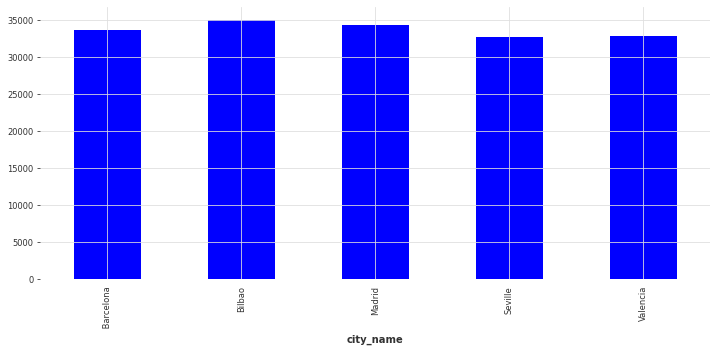

In [48]:
# As a check of number of records for each city simply check the number of temperature records and then plot.
df_weather.groupby(["city_name"])[['temp']].count().plot.bar(color="blue", legend=False, figsize=(12,5))


# So the count of values from each site is very similar (from the above bar chart). Next check for outliers and/or incorrect values.

<AxesSubplot:>

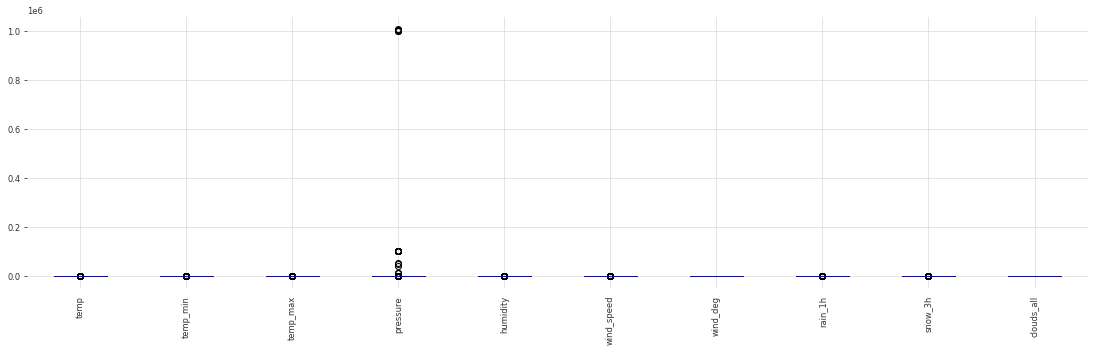

In [49]:
# boxplots for all features with labels rotated for readability. There seems to be a problem with pressure
df_weather.boxplot(rot='90', color='blue',figsize=(19, 5))

# There is definitely a problem with some pressure values. Pressure is generally measured in hectopascals hPa and actually has a tight range - definitely no less than 950 or higher that 1050. Here is a link to record values for Spanish max/min pressure - min is 950hPa, max is 1051hPa so will use these to cut off values. https://en.wikipedia.org/wiki/List_of_atmospheric_pressure_records_in_Europe#Spain  

In [50]:
# from the above there seems to be a problem with pressure
df_weather['pressure'].describe()

count    1.684560e+05
mean     1.073121e+03
std      6.143207e+03
min      0.000000e+00
25%      1.014000e+03
50%      1.018000e+03
75%      1.022000e+03
max      1.008371e+06
Name: pressure, dtype: float64

# So lets look at the spread and count of values less than 945 or greater than 1055 (1309 with bad pressure values)

In [51]:
sum(df_weather['pressure']<=955) + sum(df_weather['pressure']>=1051)

1228

In [52]:
# examining some records shows that the pressure is just wrong - see the pressure column.
df_weather[df_weather['pressure']>=1051]

city_name    temp  temp_min  temp_max  pressure  \
dt_iso                                                                        
2016-07-21 19:00:00+00:00    Valencia  298.94    298.71    299.26      1073   
2016-08-03 15:00:00+00:00    Valencia  308.34    302.75    312.04      1075   
2016-08-03 16:00:00+00:00    Valencia  305.31    302.75    306.48      1074   
2016-08-03 17:00:00+00:00    Valencia  304.55    302.55    305.37      1073   
2016-08-03 18:00:00+00:00    Valencia  302.94    301.65    303.71      1074   
...                               ...     ...       ...       ...       ...   
2015-02-22 09:00:00+00:00   Barcelona  283.86    283.86    283.86     10029   
2015-02-22 10:00:00+00:00   Barcelona  285.05    285.05    285.05    100304   
2015-02-22 11:00:00+00:00   Barcelona  285.45    285.45    285.45    100242   
2015-02-22 13:00:00+00:00   Barcelona  286.55    286.55    286.55    100164   
2015-10-17 01:00:00+00:00     Seville  293.51    289.15    300.15      1090   

                           humidity  wind_speed  wind_deg  rain_1h  snow_3h  \
dt_iso                                                                        
2016-07-21 19:00:00+00:00        41           3       107      0.0      0.0   
2016-08-03 15:00:00+00:00        46           1       292      0.0      0.0   
2016-08-03 16:00:00+00:00        45           1       315      0.0      0.0   
2016-08-03 17:00:00+00:00        47           0       180      0.0      0.0   
2016-08-03 18:00:00+00:00        47           1       135      0.0      0.0   
...                             ...         ...       ...      ...      ...   
2015-02-22 09:00:00+00:00         0           1        67      0.0      0.0   
2015-02-22 10:00:00+00:00         0           6        67      0.0      0.0   
2015-02-22 11:00:00+00:00         0           7       337      0.0      0.0   
2015-02-22 13:00:00+00:00         0           1         0     12.0      0.0   
2015-10-17 01:00:00+00:00        87           2        30      0.0      0.0   

                           clouds_all weather_main  
dt_iso                                              
2016-07-21 19:00:00+00:00           0        clear  
2016-08-03 15:00:00+00:00          32       clouds  
2016-08-03 16:00:00+00:00           8        clear  
2016-08-03 17:00:00+00:00          20       clouds  
2016-08-03 18:00:00+00:00          20       clouds  
...                               ...          ...  
2015-02-22 09:00:00+00:00           0        clear  
2015-02-22 10:00:00+00:00           0        clear  
2015-02-22 11:00:00+00:00           0        clear  
2015-02-22 13:00:00+00:00           0         rain  
2015-10-17 01:00:00+00:00           0        clear  

[412 rows x 12 columns]

# Based on the fact there are 169774 rows of data I will simply remove the rows with pressure errors rather than try to correct as they are ony 1309 rows out of 169774 total or 0.01% of the total.

In [53]:
# remove pressure values less than 945 and greater than 1055
df_weather = df_weather[df_weather['pressure']>= 945] 
df_weather = df_weather[df_weather['pressure']<= 1051]

In [54]:
# rows with bad pressure data removed
df_weather.shape

(167706, 12)

<AxesSubplot:>

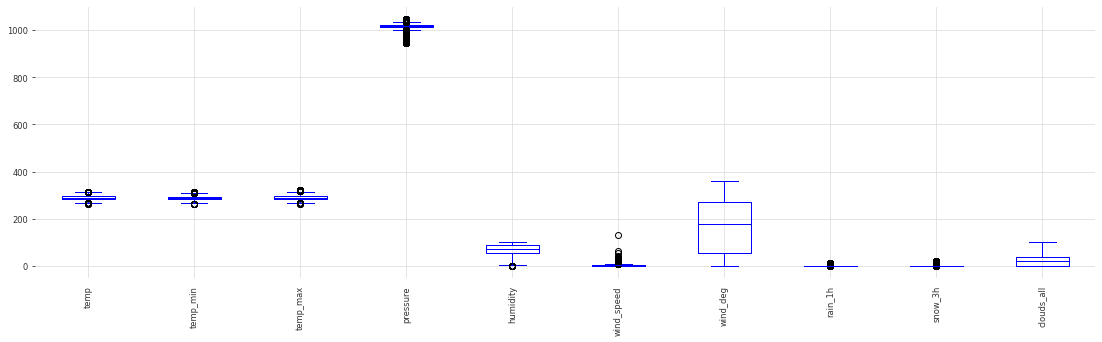

In [55]:
# boxplots for all features with labels rotated for readability.Pressue values fixed - but now wind_speed seems to have a large value
df_weather.boxplot(rot='90', color="blue",figsize=(19, 5))


<AxesSubplot:>

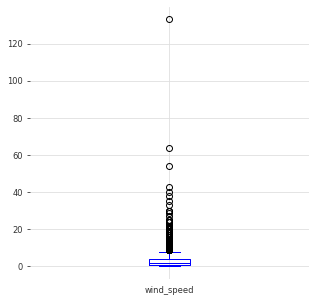

In [56]:
# checking the wind speed - max wind speed seems to be twice the next maximum and 130 km/h is a strong value
df_weather.boxplot(column='wind_speed', color="blue",figsize=(5, 5))

# Remove the windspeeds greater than 60km/h and redo boxplot - looks better now with the 134km/h and 64km/h  values removed.

<AxesSubplot:>

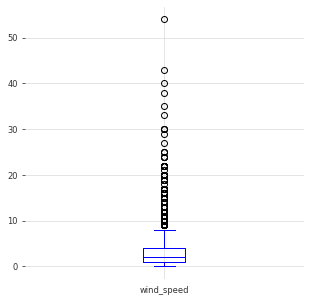

In [57]:
df_weather = df_weather[df_weather.wind_speed<=60]
df_weather.boxplot(column='wind_speed', color="blue",figsize=(5, 5))

# Last step is to convert temp, temp_min and temp_max from kelvin to celsius - simply subtract 273.15 and round to 1 decimal place and create new columns temp_C, temp_C_min, temp_C_max, then delete the temp, temp_max amd temp_min columns.

In [58]:
# convert from Kelvin to C by subtracting 273.15 and create new columns temp_C, temp_C_min, temp_C_max
df_weather['temp_C'] = round((df_weather['temp']-273.15),1)
df_weather['temp_C_max'] = round((df_weather['temp_max']-273.15),1)
df_weather['temp_C_min'] = round((df_weather['temp_min']-273.15),1)

In [59]:
df_weather.drop(columns = ['temp','temp_max','temp_min'], axis=1, inplace=True)

<AxesSubplot:>

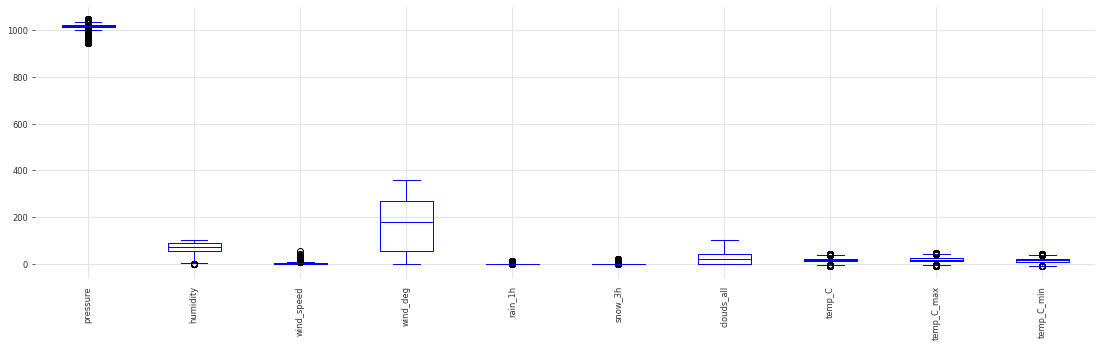

In [60]:
# boxplots for all features with labels rotated for readability.Pressue values fixed - but now wind_speed seems to have a large value
df_weather.boxplot(rot='90', color="blue",figsize=(19,5))

In [61]:
# find the names of the cities that have data
df_weather['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

## Cities in the dataset are 'Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'

# Plotting the daily temperatures of each city. It shows the Seville (red) seems to have the highest temperatures  and Bilbao (orange) and Madrid (blue) have the lowest  but the all follow the seasonal pattern.

Text(0.5, 0, 'Year')

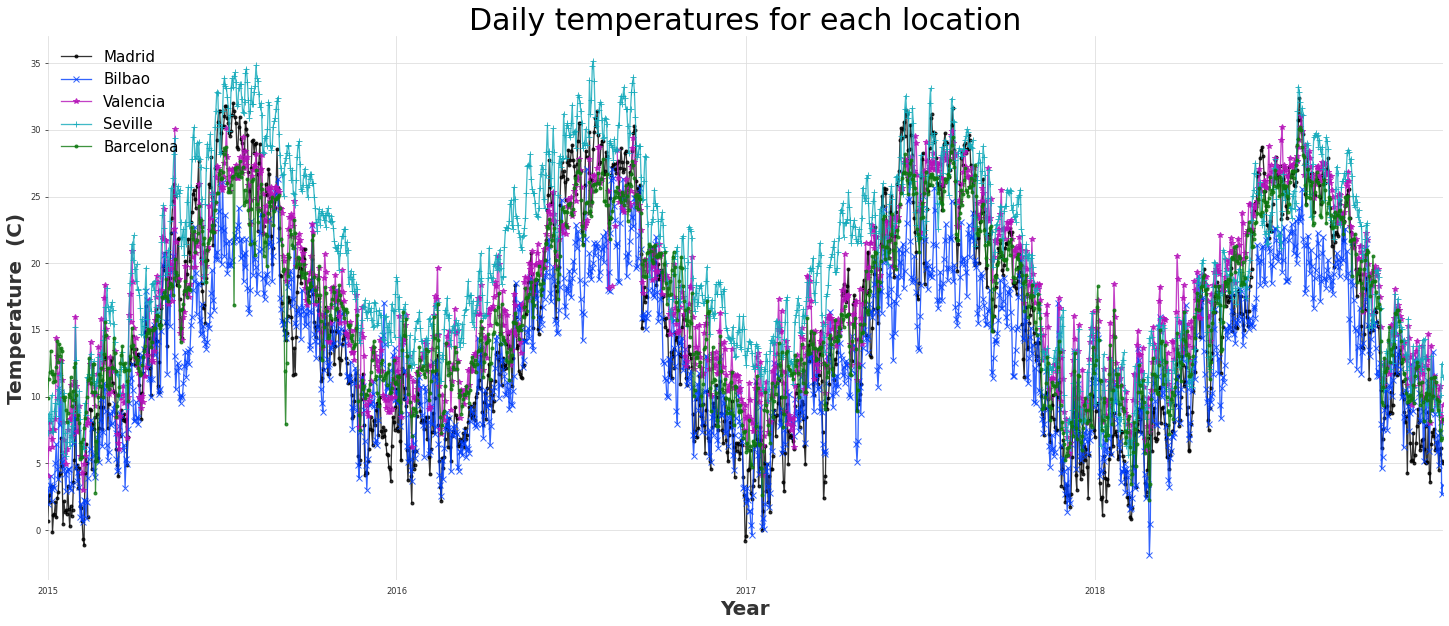

In [62]:
# Plots of daily temps for all 3 cities - to make resmpling monthly change the resample("D") to M or W for weekly
axes = df_weather[df_weather.city_name=='Madrid'    ]["temp_C"].resample("D").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='Madrid' )
axes = df_weather[df_weather.city_name=='Bilbao'    ]["temp_C"].resample("D").mean().plot(marker='x', alpha=0.8,  figsize=(25,10), label='Bilbao')
axes = df_weather[df_weather.city_name=='Valencia'  ]["temp_C"].resample("D").mean().plot(marker='*', alpha=0.8,  figsize=(25,10), label='Valencia')
axes = df_weather[df_weather.city_name=='Seville'   ]["temp_C"].resample("D").mean().plot(marker='+', alpha=0.8,  figsize=(25,10), label='Seville')
axes = df_weather[df_weather.city_name==' Barcelona']["temp_C"].resample("D").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='Barcelona')
axes.legend(loc='upper left', frameon=False, fontsize=15)
axes.set_title('Daily temperatures for each location', fontsize=30)
axes.set_ylabel('Temperature  (C)', fontsize=20)
axes.set_xlabel("Year", fontsize=20)

# With data imported and cleaned the questions posed can now be examine (from competition page)

## The dataset is unique because it contains hourly data for electrical consumption and the respective forecasts by the TSO for consumption and pricing. This allows prospective forecasts to be benchmarked against the current state of the art forecasts being used in industry.

### <i>   1. Visualize the load and marginal supply curves.      </i>                                                   
### <i>   2. What weather measurements, and cities influence most the electrical demand, prices, generation capacity?</i>       
### <i>   3. Can we forecast 24 hours in advance better than the TSO?</i>       
### <i>   4. Can we predict electrical price by time of day better than TSO?</i>       
### <i>   5. Forecast intraday price or electrical demand hour-by-hour.</i>       
### <i>   6. What is the next generation source to be activated on the load curve?</i>       

# ***************************************************************************************************************************

# <b>1. <i>Visualize the load and marginal supply curve - namely a scatter plot of total load versus total cost for each hourly data point - line of best fit in red</i></b>
## Through the scatter graph and the line of best fit there can be seen a gentle relationship between highter hourly demand and higher hourly prices


Text(0.5, 1.0, 'Total load versus Price')

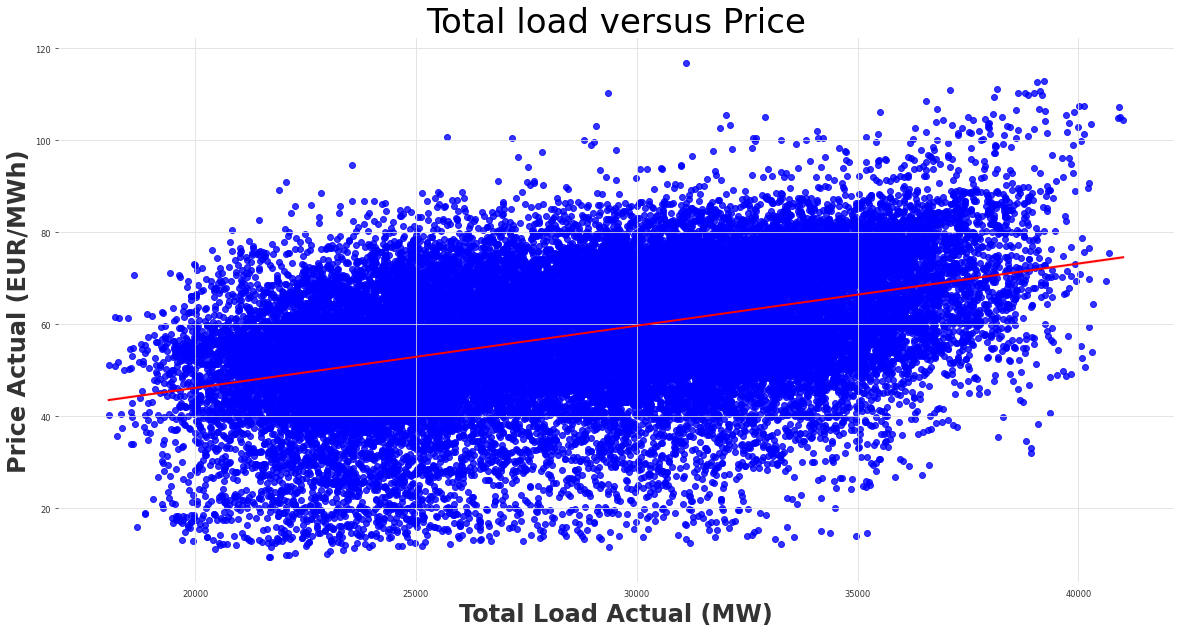

In [63]:
# plot of hours actual price vs hourly total load
plt.figure(figsize=(20,10))
# plot in blue with line of best fit in red
sns.regplot(x=df_energy['total load actual'],y=df_energy['price actual'], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel('Price Actual (EUR/MWh)', fontsize=24)
plt.xlabel('Total Load Actual (MW)', fontsize=24)
plt.title("Total load versus Price", fontsize=34)

# Next plots show the range of hourly electricity demand. There are 2 peaks in usage, the 11,12,13 hours and then again 19,20,21 hours with a minimum at 4am in the early morning. 

Text(0.5, 1.0, 'Hourly boxplots of total load')

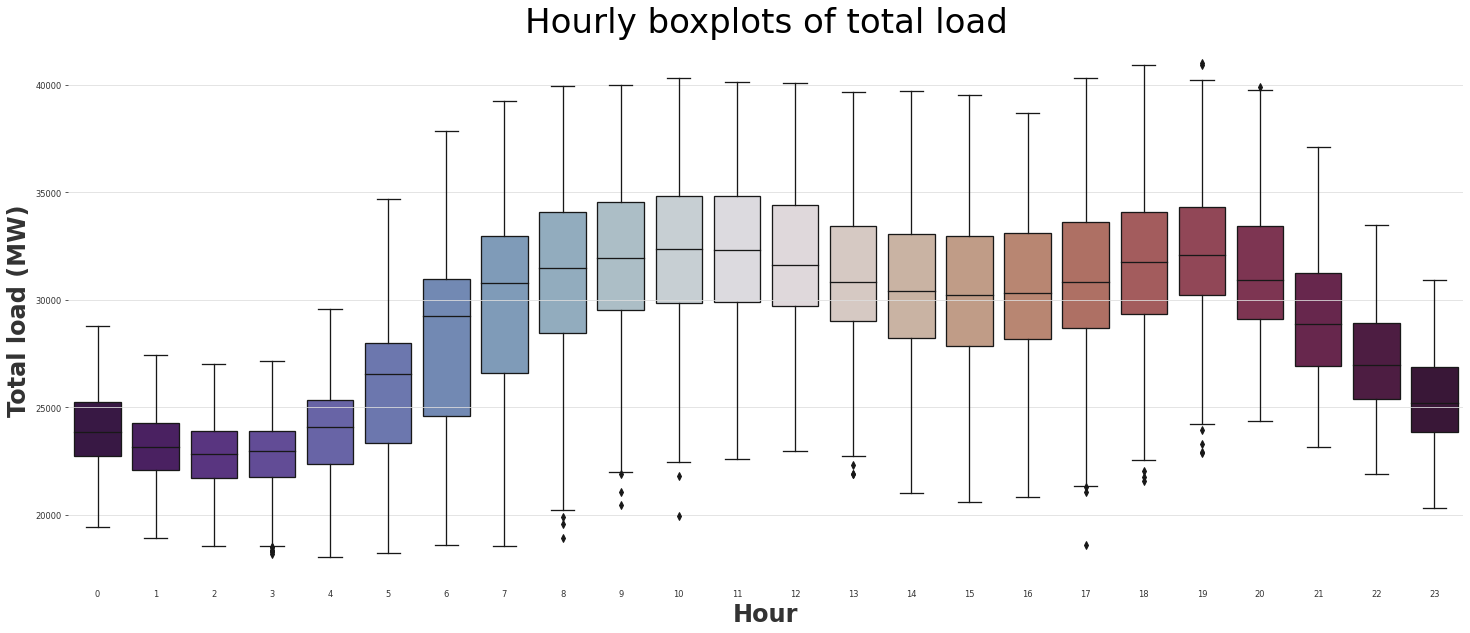

In [64]:
# Visualise by total actual load by hour

sns.boxplot(x=df_energy.index.hour, y='total load actual', data=df_energy,palette="twilight_shifted")
plt.ylabel('Total load (MW)', fontsize=24)
plt.xlabel('Hour', fontsize=24)
plt.title("Hourly boxplots of total load", fontsize=34)

# from the above graph it seems there are still some problems with outliers - will deal with later if i get the chance - future work

# Now to visualise cost per hour - not as much variation though follows the same pattern

Text(0.5, 1.0, 'Hourly boxplots of Price Actual')

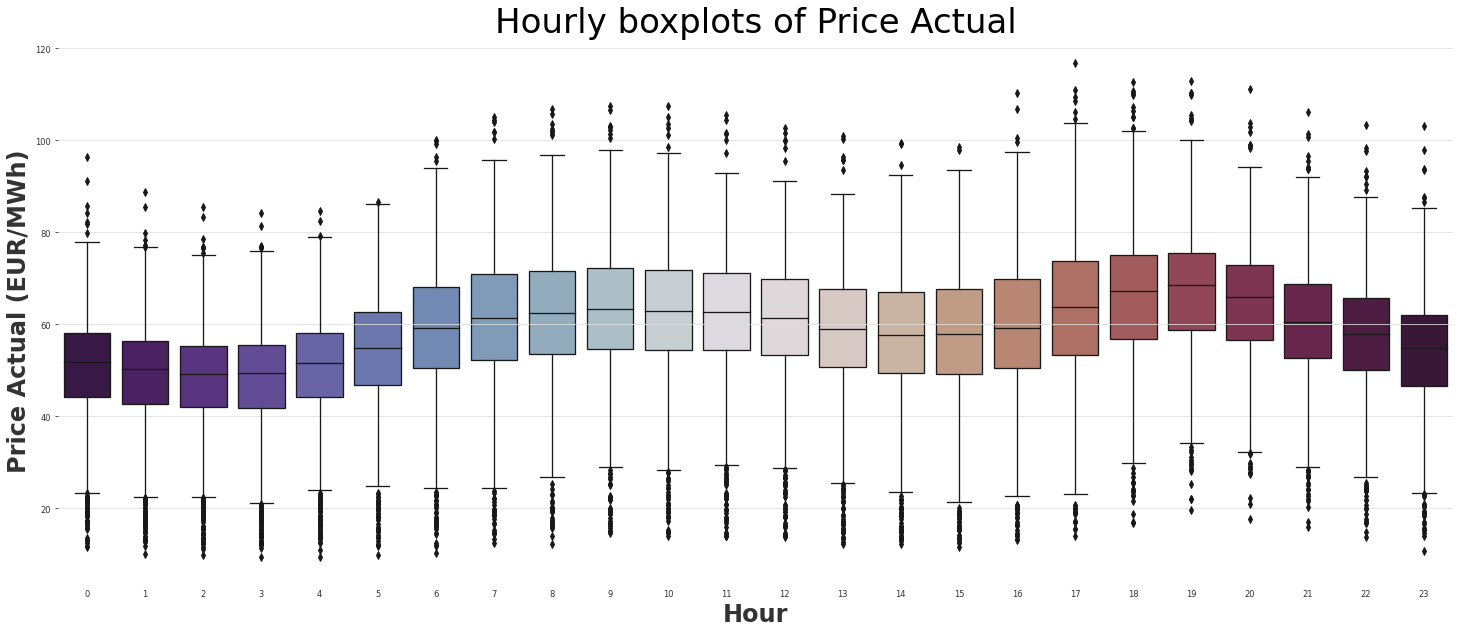

In [65]:
# Now to visualise cost by hour

sns.boxplot(x=df_energy.index.hour, y='price actual', data=df_energy,palette="twilight_shifted")
plt.ylabel('Price Actual (EUR/MWh)', fontsize=24)
plt.xlabel('Hour', fontsize=24)
plt.title("Hourly boxplots of Price Actual", fontsize=34)

# By month the greatest usage is in winter months January and February, and lowest in spring April/May and then high again in summer June/July, this links in to the idea that there is greater enery demand in either hot or cold conditions

Text(0.5, 1.0, 'Monthly boxplots of total load Actual')

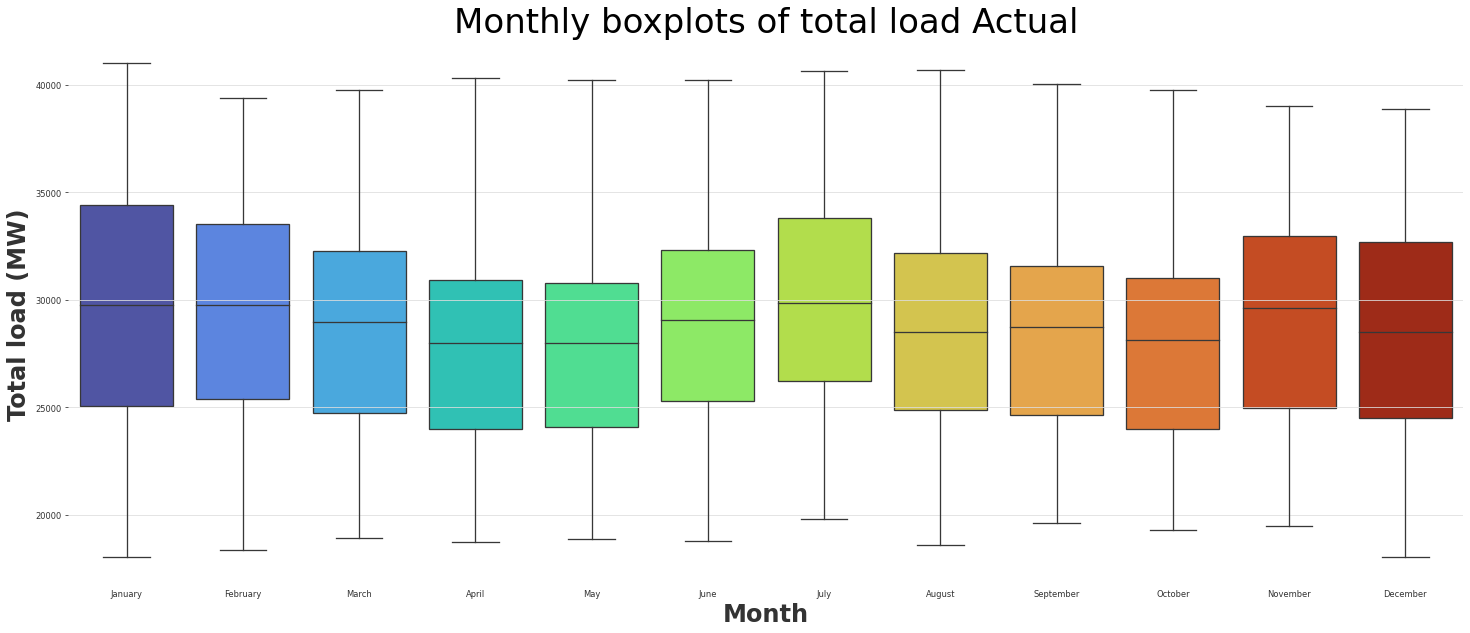

In [66]:
# Now to visualise load by month

sns.boxplot(x=df_energy.index.month_name(), y='total load actual', data=df_energy, palette="turbo")
plt.ylabel('Total load (MW) ', fontsize=24)
plt.xlabel('Month', fontsize=24)
plt.title("Monthly boxplots of total load Actual", fontsize=34)

# Another interesting view is Total Load by day of week - this matches our understanding - most days are similar with Saturday much less and Sunday the least.

Text(0.5, 1.0, 'Daily boxplots of total load actual')

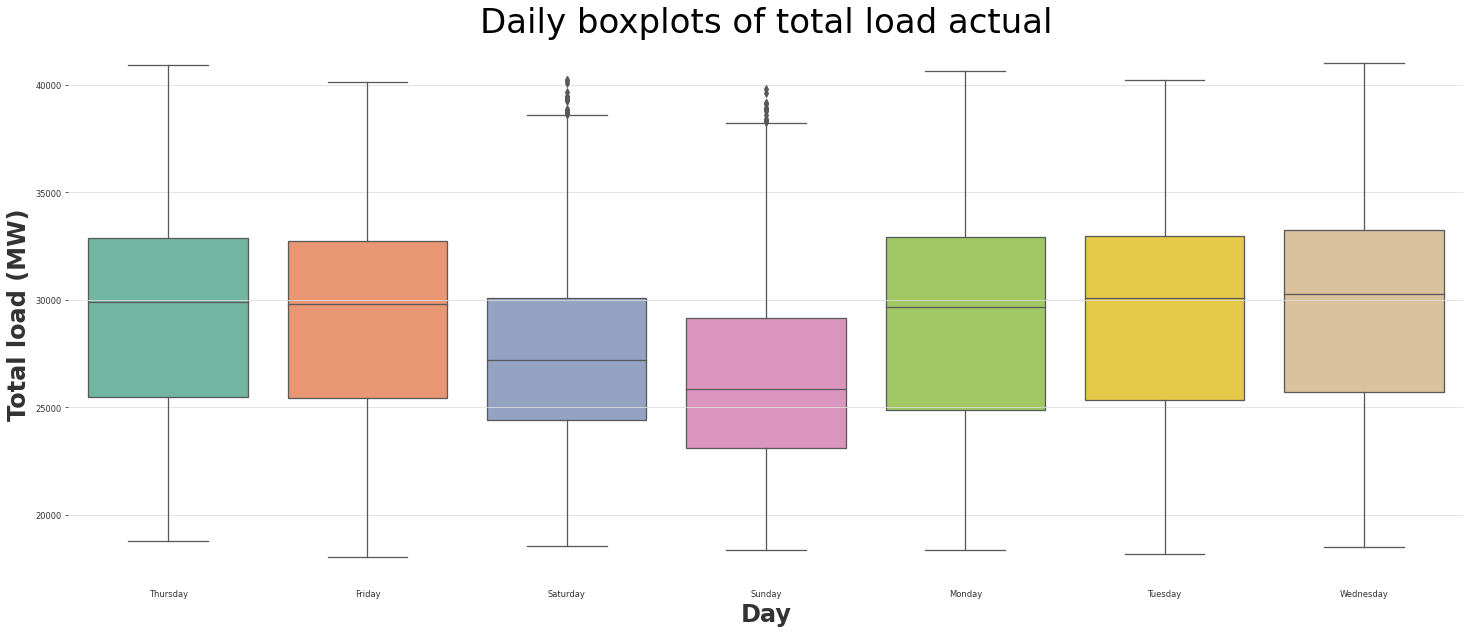

In [67]:
# Now to visualise laod by day

sns.boxplot(x=df_energy.index.day_name(), y='total load actual', data=df_energy, palette="Set2")
plt.ylabel('Total load (MW) ', fontsize=24)
plt.xlabel('Day', fontsize=24)
plt.title("Daily boxplots of total load actual", fontsize=34)

Text(0.5, 1.0, 'Daily boxplots of price actual')

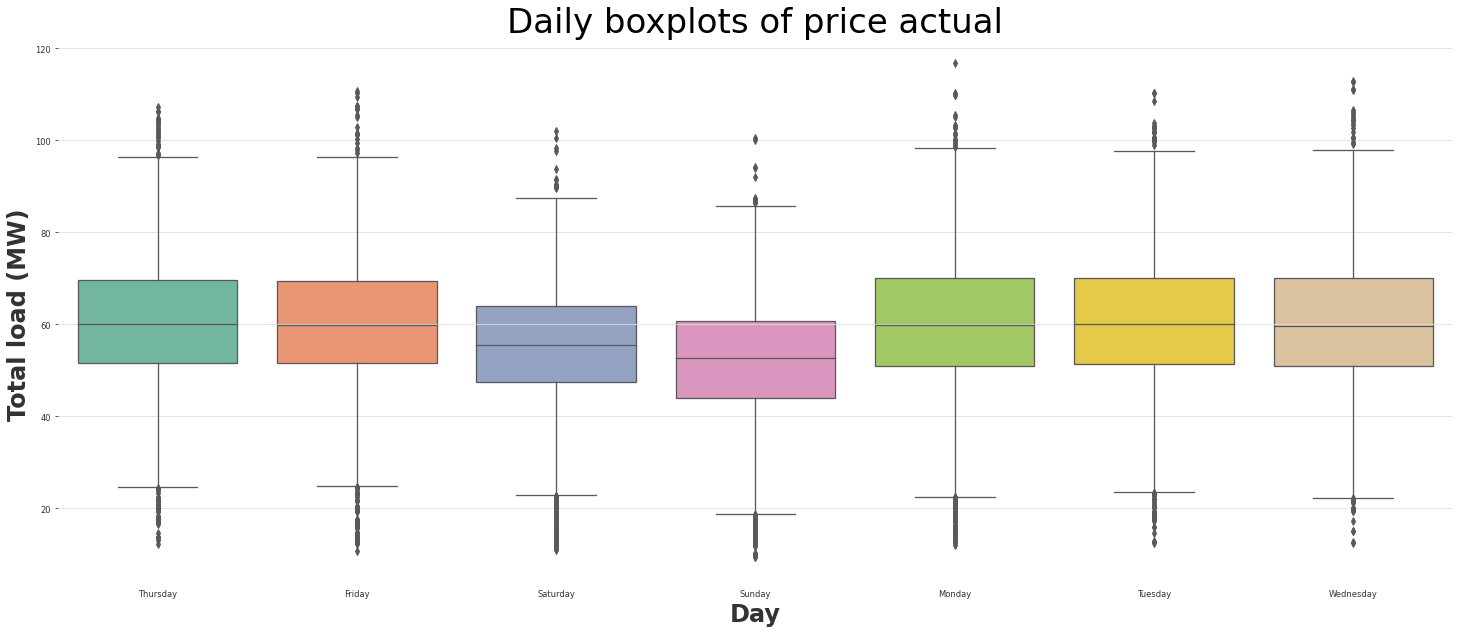

In [68]:
# Now to visualise laod by day

sns.boxplot(x=df_energy.index.day_name(), y='price actual', data=df_energy, palette="Set2")
plt.ylabel('Total load (MW) ', fontsize=24)
plt.xlabel('Day', fontsize=24)
plt.title("Daily boxplots of price actual", fontsize=34)

Text(0.5, 1.0, 'Monthly boxplots of Price Actual')

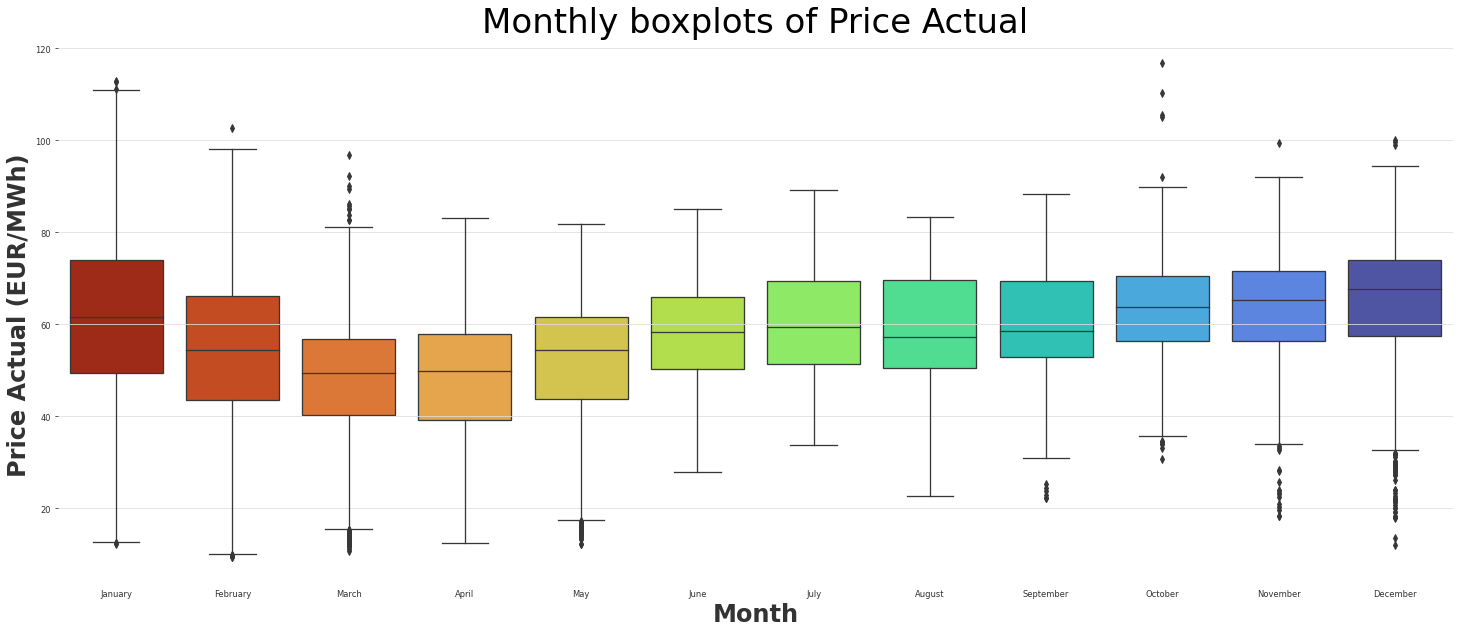

In [69]:
# Now to visualise cost by month

sns.boxplot(x=df_energy.index.month_name(), y='price actual', data=df_energy, palette="turbo_r")
plt.ylabel('Price Actual (EUR/MWh) ', fontsize=24)
plt.xlabel('Month', fontsize=24)
plt.title("Monthly boxplots of Price Actual", fontsize=34)

# <b>   2. <i>What weather measurements, and cities influence most the electrical demand, prices, generation capacity?</i></b>

## To answer this need to look at: temperatures/humidity for demand (air-conditioning/heating), cloud free days for solar generation, windiest location for wind power generation.

##  Cities in the weather dataset are : 'Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'

## Let's get max/min/mean values for temperature/humidity/wind_speed - as in the dataset exploration in the beginning, the highest mean temperature is Seville (and also the maximum temp value), the coldest is Barcelona, Madrid has the lowest humidity and they all have similar mean wind speed - first as the values, then displayed as boxplots.

In [70]:
# # group by city min/max/mean temps, humidity and wind speed
temps = ['temp_C', 'humidity','wind_speed']
df_weather.groupby(df_weather['city_name'])[temps].agg({'min','max','mean'}).round(1)

temp_C             humidity           wind_speed         
              max   min  mean      max min  mean        max min mean
city_name                                                           
 Barcelona   36.0 -10.9  16.7      100   0  73.2         15   0  2.8
Bilbao       39.3  -6.3  13.2      100  11  79.0         15   0  2.0
Madrid       40.2  -9.0  15.1      100   0  59.1         18   0  2.4
Seville      42.5  -2.1  20.1      100   7  64.0         15   0  2.5
Valencia     38.0  -4.3  17.6      100   8  64.6         54   0  2.8

 Barcelona         AxesSubplot(0.1,0.679412;0.363636x0.220588)
Bilbao        AxesSubplot(0.536364,0.679412;0.363636x0.220588)
Madrid             AxesSubplot(0.1,0.414706;0.363636x0.220588)
Seville       AxesSubplot(0.536364,0.414706;0.363636x0.220588)
Valencia               AxesSubplot(0.1,0.15;0.363636x0.220588)
dtype: object

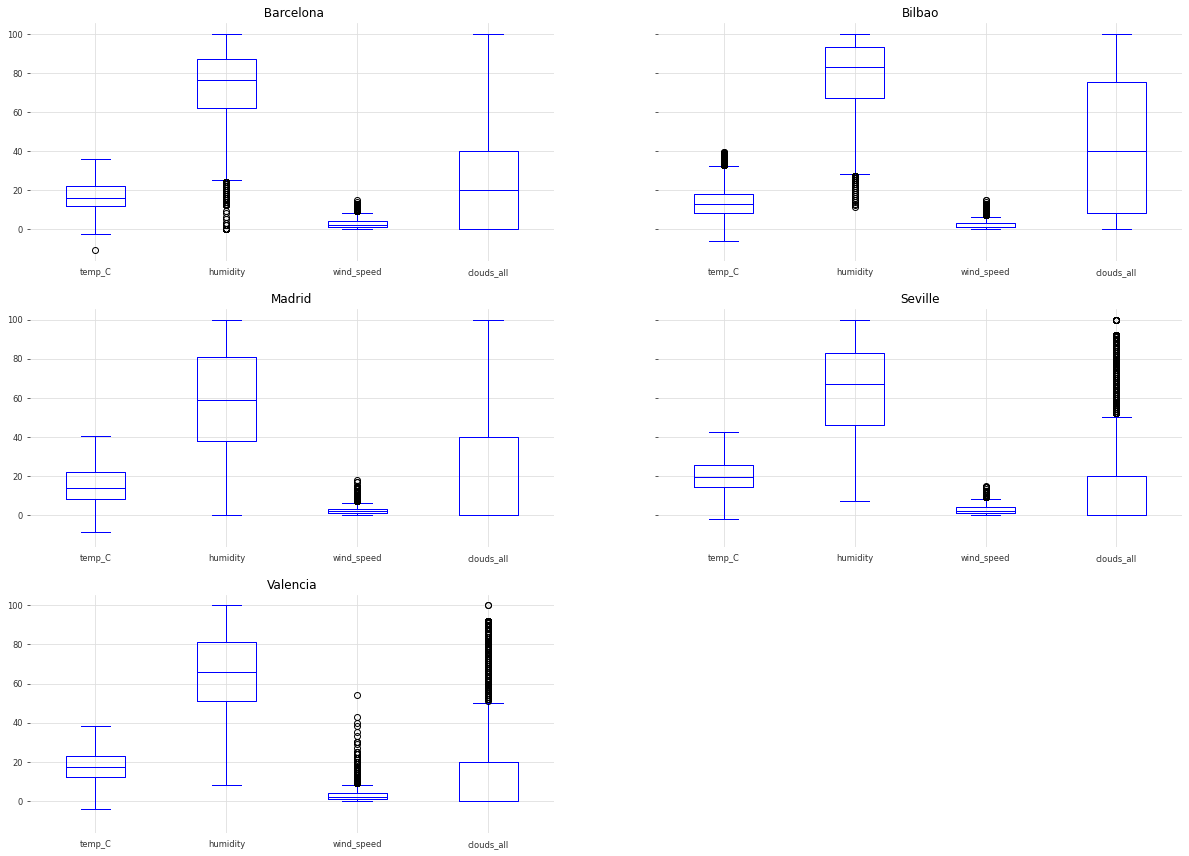

In [71]:
# # group by city mean temps and wind speed - no need to display pressure as scale id different and not that important.
temps = ['city_name','temp_C','humidity','wind_speed','clouds_all']
df_weather[temps].groupby(['city_name']).boxplot(color="blue",figsize=(20,15))

# Another way of viewing cloud data is via simple plot - the visual density would seem to suggest Bilboa is the cloudiest and Madrid/Seville the least cloudy.

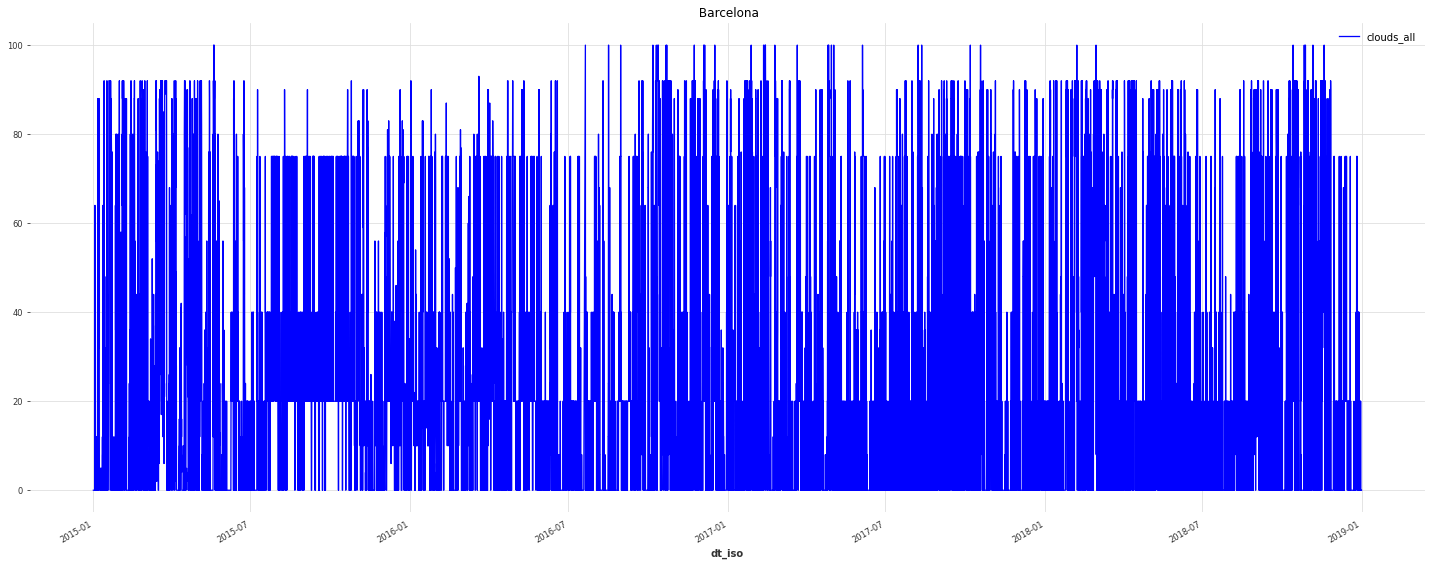

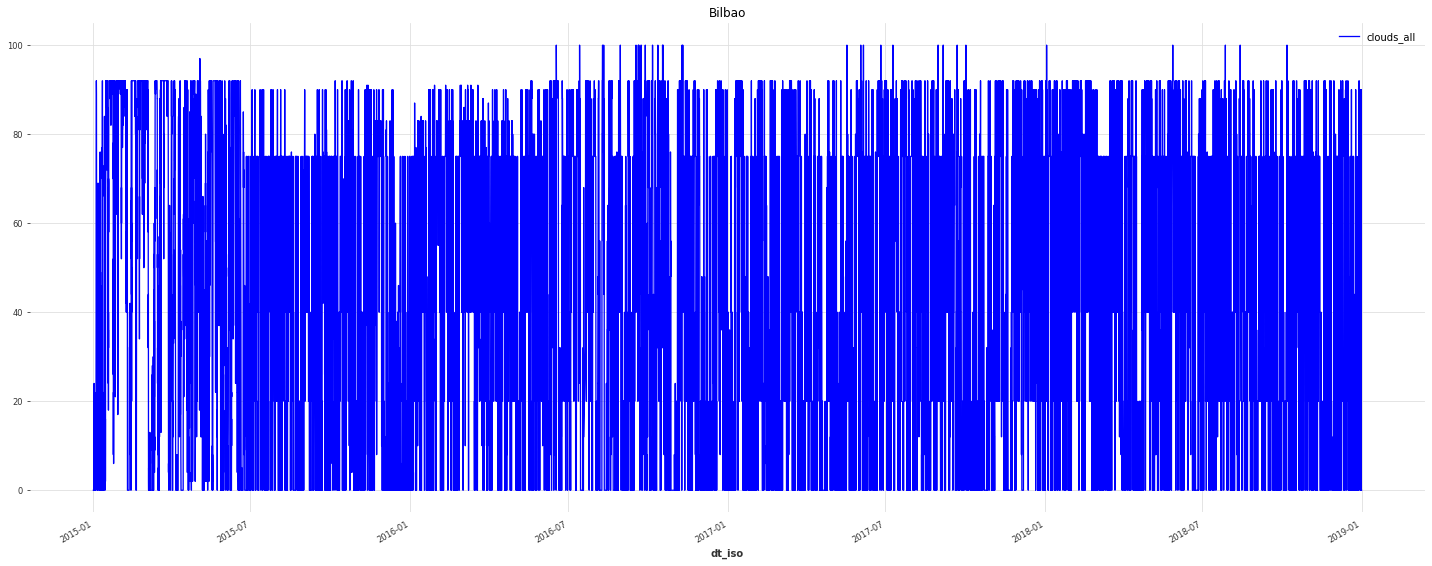

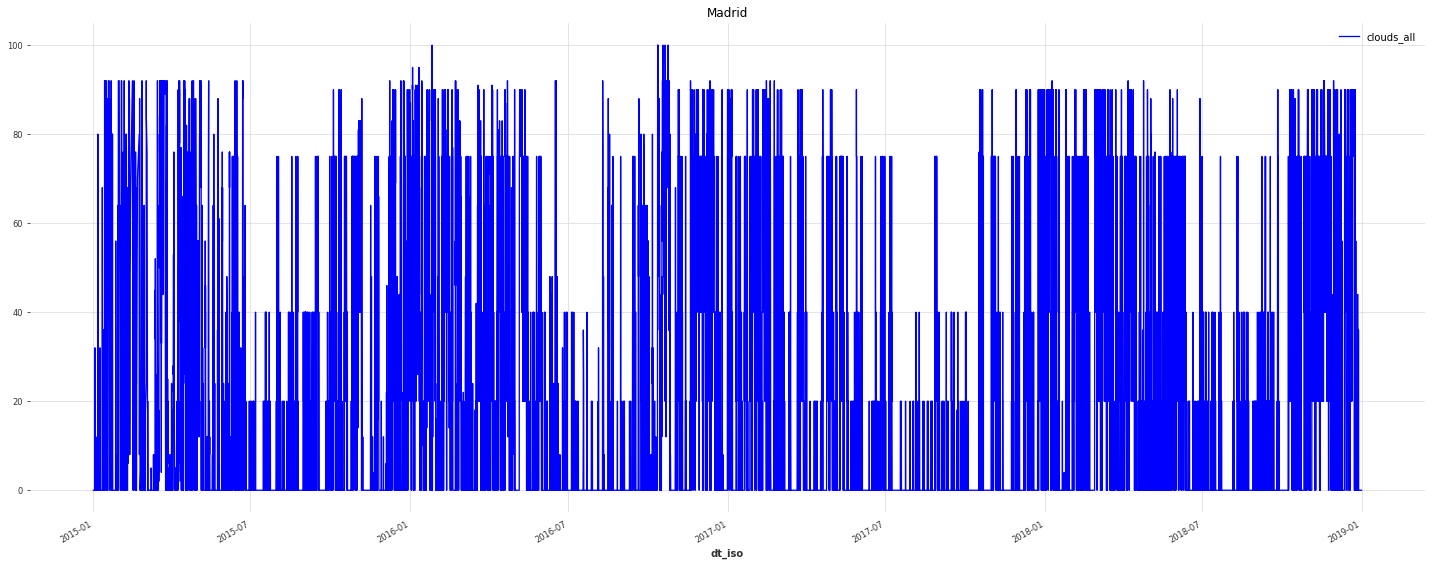

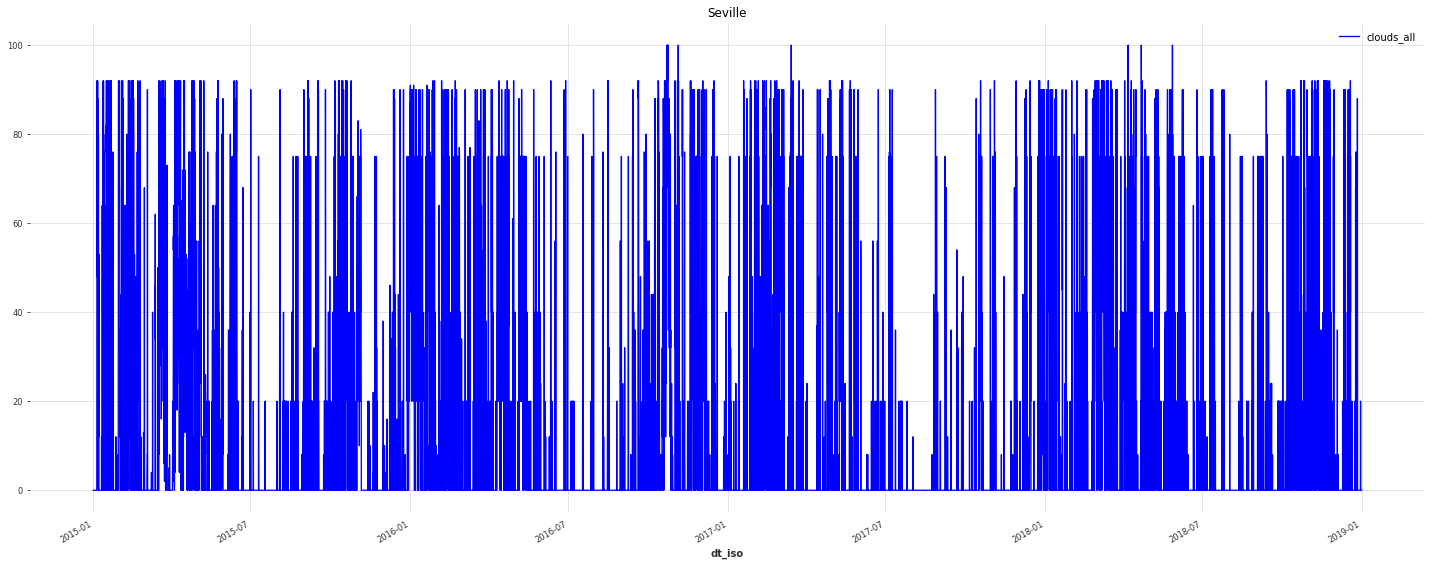

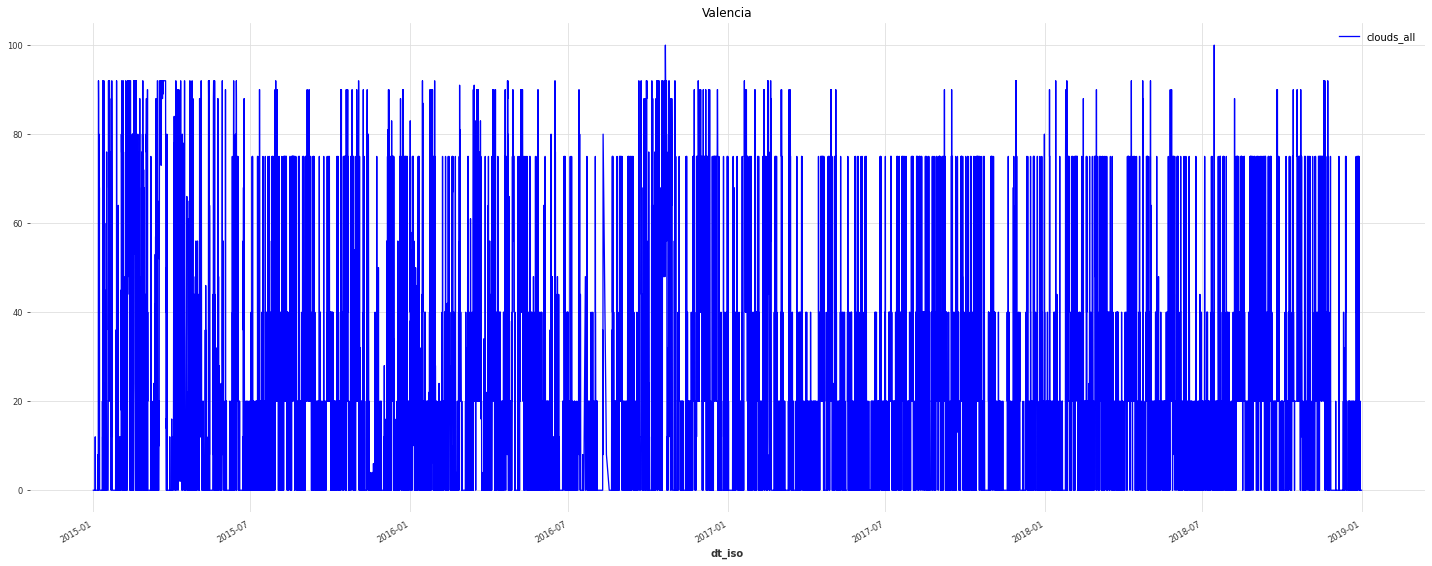

In [72]:
# graph the clouds for each city
grp = df_weather.groupby('city_name')[['clouds_all']] 
for key in grp.groups.keys():
    grp.get_group(key).plot(title=key, color='blue')

# Very simply as Madrid is the least cloudy that's the best spot for solar generation, and Valencia seems to have the highest values for wind although all cities have a similar mean. 

## Below is a plot of both daily and monthly average temperature for each city and the monthly total load (divided by 1000 to allow it to fit on the same graph) and price. There is some indication of seasonality in the total load, namely 2 peaks per year, one in January and one in June/July. This makes sense as it relates to the need for cooling (air conditioners) in summer and heating (electric heaters) in winter. The first graph (daily values) is a bit messy so the same data is resampled monthly to give a cleaner plot in the second graph.

## It is very difficult to see any particular pattern in the pricing with some maximums in July and January but also minimums there and max/mins in other months.

Text(0.5, 0, 'Year')

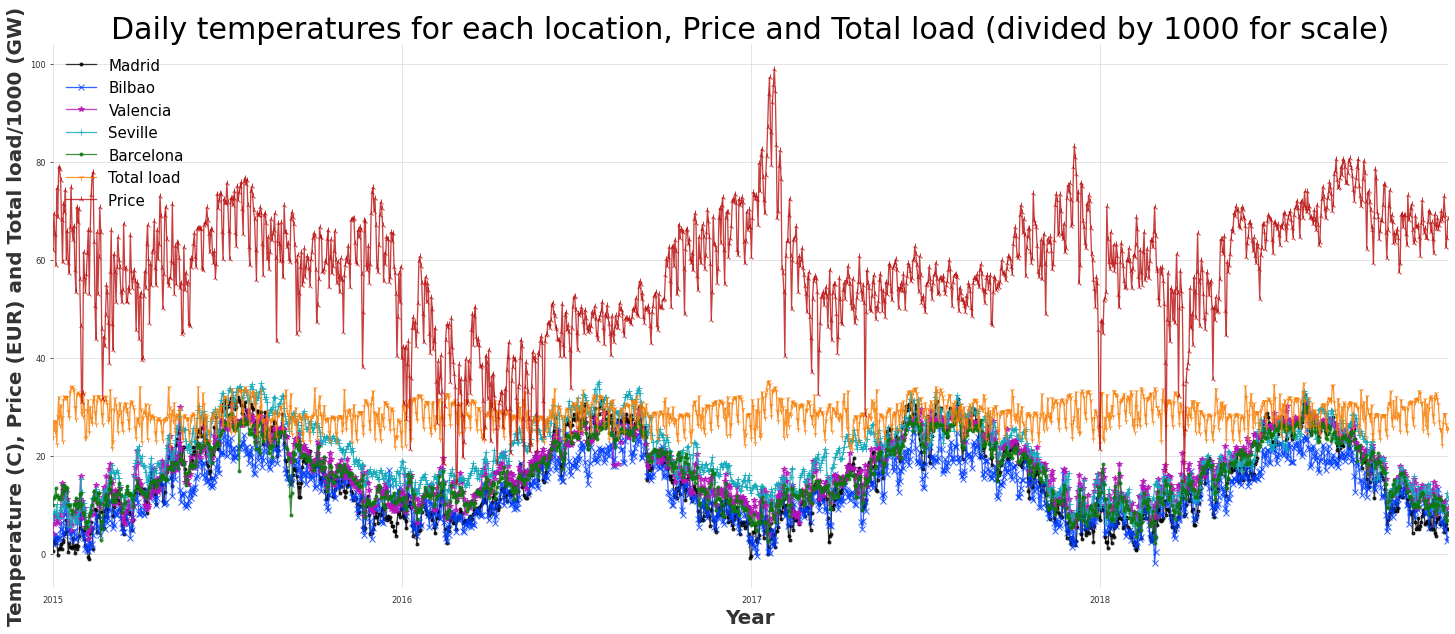

In [73]:
# Plots of daily temps for all 3 cities - change the resample value from M to D for Daily,  H for Hourly or W for Weekly.
axes = df_weather[df_weather.city_name=='Madrid'    ]["temp_C"].resample("D").mean().plot(marker='.', alpha=0.8,  label='Madrid' )
axes = df_weather[df_weather.city_name=='Bilbao'    ]["temp_C"].resample("D").mean().plot(marker='x', alpha=0.8,  label='Bilbao')
axes = df_weather[df_weather.city_name=='Valencia'  ]["temp_C"].resample("D").mean().plot(marker='*', alpha=0.8,  label='Valencia')
axes = df_weather[df_weather.city_name=='Seville'   ]["temp_C"].resample("D").mean().plot(marker='+', alpha=0.8,  label='Seville')
axes = df_weather[df_weather.city_name==' Barcelona']["temp_C"].resample("D").mean().plot(marker='.', alpha=0.8,  label='Barcelona')
# divide total load by 1000 to get similar scale
axes = df_energy['total load actual'].resample("D").mean().div(1000).plot(marker='1', alpha=0.8,   label='Total load')
axes = df_energy['price actual'].resample("D").mean().plot(marker='2', alpha=0.8, label='Price ')
axes.legend(loc='best', frameon=False, fontsize=15)
axes.set_title('Daily temperatures for each location, Price and Total load (divided by 1000 for scale)', fontsize=30)
axes.set_ylabel('Temperature (C), Price (EUR) and Total load/1000 (GW)', fontsize=20)
axes.set_xlabel("Year", fontsize=20)

# Below is the same graph as as above but resampled monthly rather than daily to make the graph easier to visualise

Text(0.5, 0, 'Year')

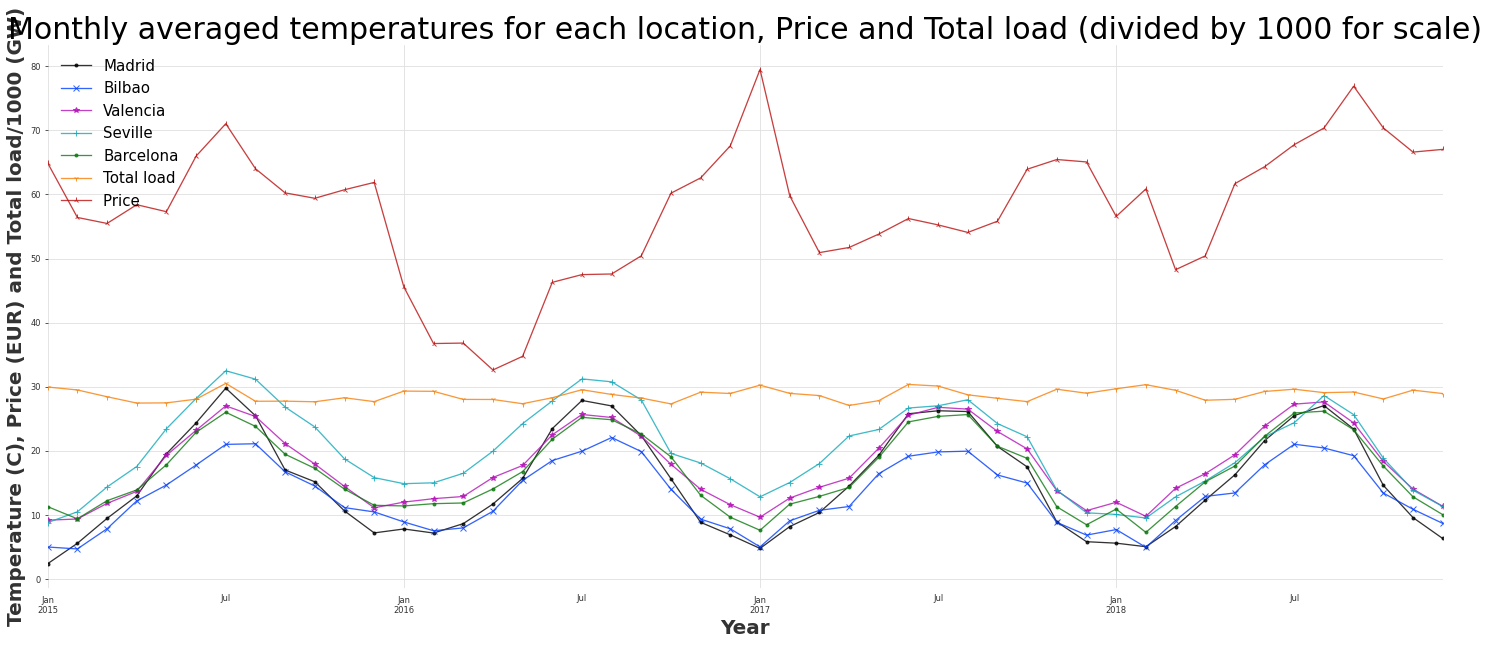

In [74]:
# Plots of daily temps for all 3 cities - change the resample value from M to D for Daily,  H for Hourly or W for Weekly.
axes = df_weather[df_weather.city_name=='Madrid'    ]["temp_C"].resample("M").mean().plot(marker='.', alpha=0.8, label='Madrid' )
axes = df_weather[df_weather.city_name=='Bilbao'    ]["temp_C"].resample("M").mean().plot(marker='x', alpha=0.8,  label='Bilbao')
axes = df_weather[df_weather.city_name=='Valencia'  ]["temp_C"].resample("M").mean().plot(marker='*', alpha=0.8,  label='Valencia')
axes = df_weather[df_weather.city_name=='Seville'   ]["temp_C"].resample("M").mean().plot(marker='+', alpha=0.8,  label='Seville')
axes = df_weather[df_weather.city_name==' Barcelona']["temp_C"].resample("M").mean().plot(marker='.', alpha=0.8, label='Barcelona')
# divide total load by 1000 to get similar scale
axes = df_energy['total load actual'].resample("M").mean().div(1000).plot(marker='1', alpha=0.8,  label='Total load')
axes = df_energy['price actual'].resample("M").mean().plot(marker='2', alpha=0.8,  label='Price ')
axes.legend(loc='best', frameon=False, fontsize=15)
axes.set_title('Monthly averaged temperatures for each location, Price and Total load (divided by 1000 for scale)', fontsize=30)
axes.set_ylabel('Temperature (C), Price (EUR) and Total load/1000 (GW)', fontsize=20)
axes.set_xlabel("Year", fontsize=20)

# Lastly to see if temperature affects the total demand a simple plot of temperature versus demand will be shown - a patterns will emerge - firstly graph monthly mean, then daily mean and finally hourly mean vs total hourly demand at the same samply frequency.
## An obvious pattern emerges with both warmer and colder temperatures having higher total loads - the pattern is more obvious when averaged over a month, on a daily average the pattern is not really recognisable but there is evidence of a pattern in the hourly data - though not as cleanly displayed.

# Thus is can be stated that temperature does play a role in electricity demand, in both higher and low temperatures the demand is greater.

Text(0.5, 1.0, 'Monthly Temperature versus Monthly Total Load')

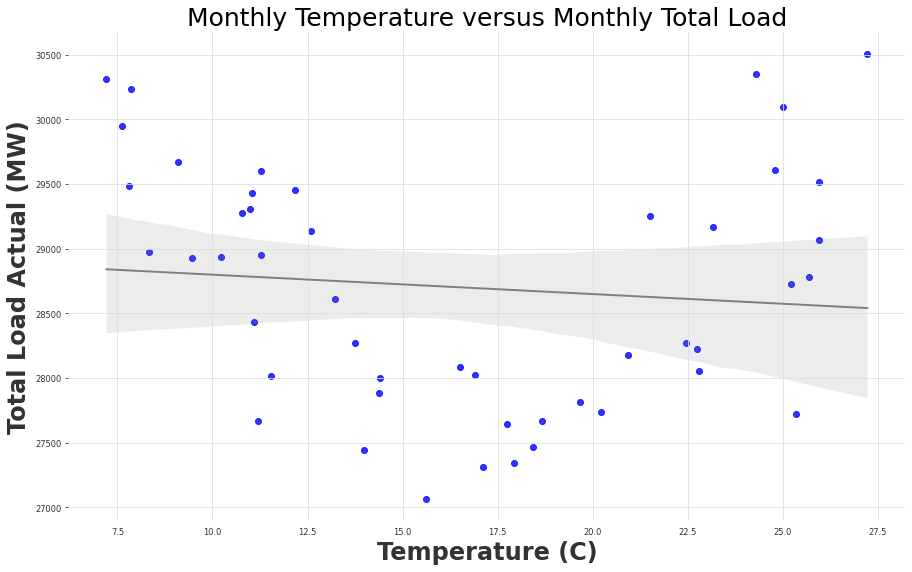

In [75]:
# Firstly monthly resamples
mean_temp   = df_weather[["temp_C"]].resample("M").mean() 
mean_energy = df_energy[['total load actual']].resample("M").mean()
#join the 2 df's
to_concat = [mean_temp,mean_energy]
result = pd.concat(to_concat,axis=1)

# plot of hours actual price vs hourly total load
plt.figure(figsize=(15,9))
# plot in blue with line of best fit in red
sns.regplot(x=result['temp_C'],y=result['total load actual'], scatter_kws={"color": "blue"}, line_kws={"color": "grey"})
plt.ylabel('Total Load Actual (MW)', fontsize=24)
plt.xlabel('Temperature (C)', fontsize=24)
plt.title("Monthly Temperature versus Monthly Total Load", fontsize=25)

Text(0.5, 1.0, 'Daily Temperature versus Daily Total Load')

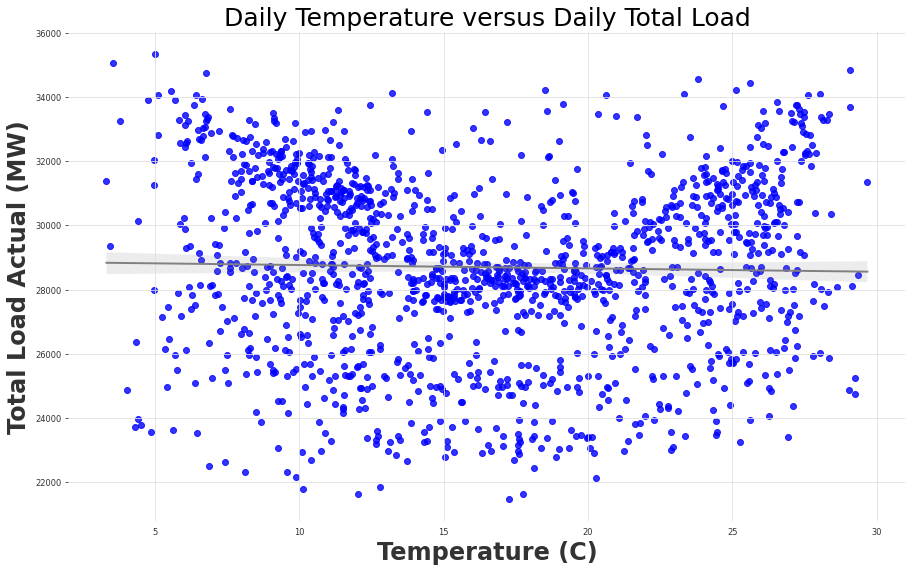

In [76]:
# Second daily resamples
mean_temp   = df_weather[["temp_C"]].resample("D").mean() 
mean_energy = df_energy[['total load actual']].resample("D").mean()
#join the 2 df's
to_concat = [mean_temp,mean_energy]
result = pd.concat(to_concat,axis=1)

# plot of hours actual price vs hourly total load
plt.figure(figsize=(15,9))
# plot in blue with line of best fit in red
sns.regplot(x=result['temp_C'],y=result['total load actual'], scatter_kws={"color": "blue"}, line_kws={"color": "grey"})
plt.ylabel('Total Load Actual (MW)', fontsize=24)
plt.xlabel('Temperature (C)', fontsize=24)
plt.title("Daily Temperature versus Daily Total Load", fontsize=25)

Text(0.5, 1.0, 'Hourly Temperature versus Hourly Total Load')

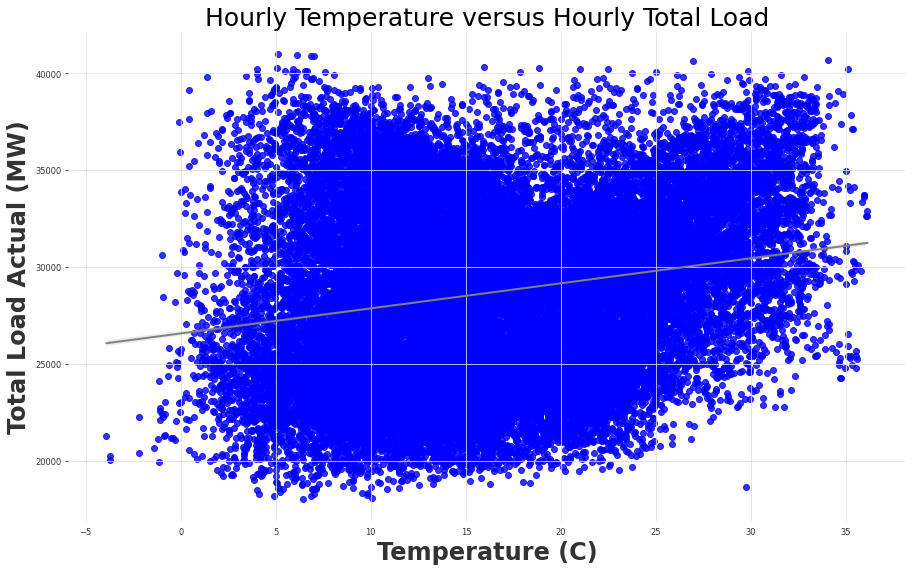

In [77]:
# lastly hourly samples
mean_temp   = df_weather[["temp_C"]].resample("H").mean() 
mean_energy = df_energy[['total load actual']].resample("H").mean()
#join the 2 df's
to_concat = [mean_temp,mean_energy]
result = pd.concat(to_concat,axis=1)

# plot of hours actual price vs hourly total load
plt.figure(figsize=(15,9))
# plot in blue with line of best fit in red
sns.regplot(x=result['temp_C'],y=result['total load actual'], scatter_kws={"color": "blue"}, line_kws={"color": "grey"})
plt.ylabel('Total Load Actual (MW)', fontsize=24)
plt.xlabel('Temperature (C)', fontsize=24)
plt.title("Hourly Temperature versus Hourly Total Load", fontsize=25)

# <b> 3. <i>Can we forecast 24 hours in advance better than the TSO?</i></b>
### The way I am going to go about this is to use methods from within the sktime and DARTS libraries to forecast the energy use for the next day and compare that with the total load forecast feature for that day.

### For this we need to develop a model and this requires splitting data into training and testing dataset so the accuracy of the model can be assessed. The years 2015, 2016, 2017 become the training data set and 2018 becomes the test dataset to see how the models generated performs.

## The y value is simply the total load forecast value from the energy data. Since we are trying to forecast 24 hours in advance better than the TSO the resampling should be daily

### First calculate the mean average percentage error (MAPE) from the forecast versus the actual to get the TSO error - for all years

In [78]:
print('The mean absolute percentage error = {:.2f}%'.format(mean_absolute_percentage_error(df_energy['total load forecast'],df_energy['total load actual'])*100))
      #,round(mean_absolute_percentage_error(df_energy['total load forecast'],df_energy['total load actual'])*100,2),'%')

The mean absolute percentage error = 1.09%


In [79]:
# just for 2018 - no difference - so this is the number that needs to be beaten to show we can forecast better than the TSO


print('The mean absolute percentage error = {:.2f}%'.format(mean_absolute_percentage_error(df_energy['total load forecast'][df_energy.index.year==2018],df_energy['total load actual'][df_energy.index.year==2018])*100))
#      ,round(mean_absolute_percentage_error(df_energy['total load forecast'][df_energy.index.year==2018],df_energy['total load actual'][df_energy.index.year==2018])*100,2),'%')

The mean absolute percentage error = 0.92%


#  So this is the number that needs to be beaten to show we can forecast better than the TSO - a MAPE < 0.92%, but this compares the forecast to the actual and initally I am trying to learn from the first 3 years of data to predict the 4th year. A comparison is then made between the predicted forecast and the actual forecast

Text(0.5, 0, 'Year')

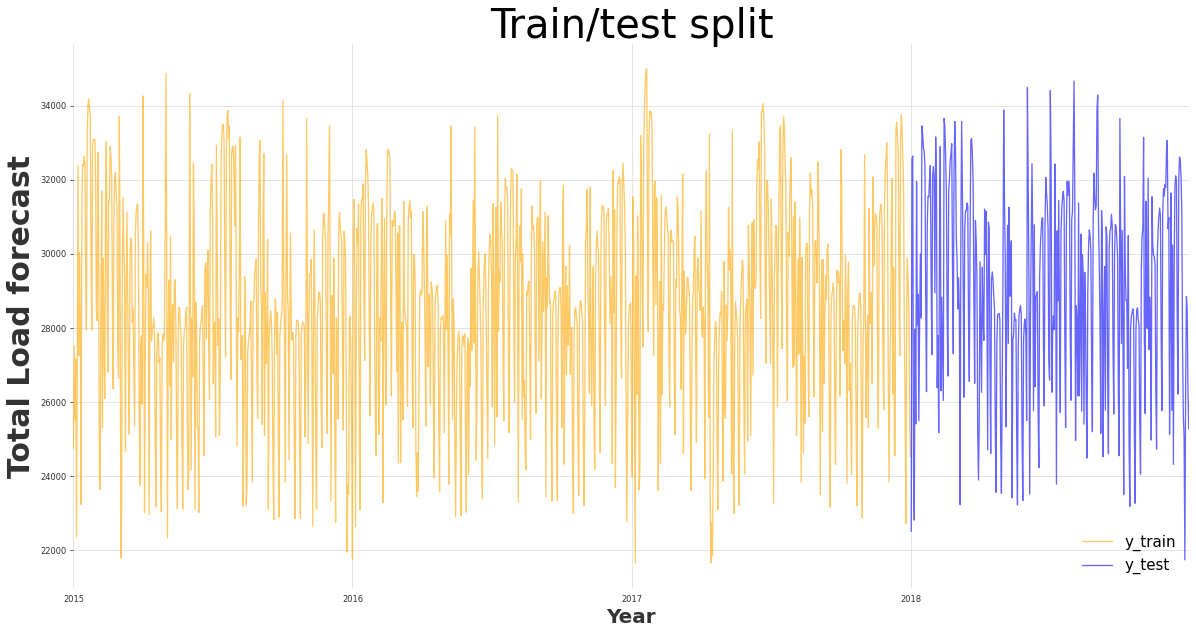

In [80]:
# Training data is years 2015, 2016,2017 and test data is 2018. - can be D M or H
y = df_energy[['total load forecast']].resample("D").mean() 
y = y.tz_localize(None)
#X = df_weather[['temp_C','humidity']]
y_train = y[y.index.year!=2018]
y_test = y[y.index.year>=2018]

# we have 4 years - so use 3 for training and 1 for testing.
#y_train, y_test = temporal_train_test_split(y, train_size=0.75)

# plot or train/test split
fig, axes = plt.subplots(1,1, figsize=(20, 10))

y_train.plot(ax=axes, alpha=0.6, color='orange') 
y_test.plot(ax=axes, alpha=0.6, color='blue') 
axes.legend(['y_train', 'y_test'], fontsize=15, loc=4)
axes.set_title('Train/test split', fontsize=40)
axes.set_ylabel('Total Load forecast', fontsize=30)
axes.set_xlabel("Year", fontsize=20)



In [81]:
# to get around the freq bug - set up the y_test, y_train index

y_train.index = pd.PeriodIndex(y_train.index, freq="D")  # added, assuming daily data - can be D M or H
y_test.index = pd.PeriodIndex(y_test.index, freq="D") 

# checking the start/end dates - they line up to the start and end times.
print('y_train start',y_train.head(1)) # start of 2015
print('y_train end  ',y_train.tail(1))   # end of 2017
print('y_test start ',y_test.head(1))   # start of 2018
print('y_test end   ',y_test.tail(1))   # end of 2018

y_train start             total load forecast
time                           
2015-01-01             24753.25
y_train end               total load forecast
time                           
2017-12-31              24533.0
y_test start              total load forecast
time                           
2018-01-01         22518.166667
y_test end                total load forecast
time                           
2018-12-31         25949.217391


# Several forecaters will try and learn the total load foreecast from 3 years of data (2015-2017) to make a prediction for the test data of 2018, some will provide graphs for simple visualisation (test/prediction comparisons). The comparison values is the Mean Average Percentage Error (MAPE)
## The Theta forecasters captures the shape but not the extremes - MAPE = 8.9%
## Exponential smoothing is slightly worse - MAPE = 13.1%

In [1]:
# this function outputs the MAPE  from the Theta forecaster using sktime

def sktime_Theta_forecasters_output():

    forecaster = ThetaForecaster(sp=365)  # if freq='H' sp = 365*24 if freq='D' sp=365, if freq='M' sp-12
    forecaster.fit(y_train)

    fh = np.arange(1,len(y_test) +1)  # forecasting horizon

    y_pred = forecaster.predict(fh)
    mean_absolute_percentage_error(y_pred, y_test)

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    #y_train.plot(ax=ax, label='y_train', style='.-')
    y_test.plot(ax=ax, label='y_test', alpha=0.5, style='.-',color='orange')
    y_pred.plot(ax=ax, label='y_predict', alpha=0.5, style='.-', color='blue')
    #df_energy['total load actual'][df_energy.index.year==2018].plot(ax=ax, label='forecast', alpha=0.5, style='.-')
    ax.legend(['y_test','y_pred'], fontsize=25, loc=2)
    ax.set_title('Test set and predictions for Theta forecaster', fontsize=40)
    ax.set_ylabel('Total Load forecast', fontsize=30)
    ax.set_xlabel("Year", fontsize=20)
    print('The symmetric mean absolute percentage error between the forecast made and the actual forecast = ',round(mean_absolute_percentage_error(y_pred, y_test)*100,1),'%')
    return y_pred

In [2]:
y_pred = sktime_Theta_forecasters_output()

NameError: name 'ThetaForecaster' is not defined

## What we actually need to compare is the predicted versus the 'total load actual' so we are comparing the prediction of the total load forecast vs total load actual for the MAPE 

In [212]:
print('The symmetric mean absolute percentage error = ',round(mean_absolute_percentage_error(y_pred, df_energy['total load actual'][df_energy.index.year==2018].resample("D").mean())*100,1),'%')  #.resample('H').mean()

The symmetric mean absolute percentage error =  8.9 %


In [446]:
# Exponential smoothing using sktime
def sktime_Exponential_Smoothing():

    forecaster = ExponentialSmoothing(trend="mul", seasonal="mul", sp=365)

    forecaster.fit(y_train)

    fh = np.arange(1,len(y_test)+1 )  # forecasting horizon
    y_pred = forecaster.predict(fh)
    #plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    #mean_absolute_percentage_error(y_pred, y_test)
    print('The mean absolute percentage error = {:.2f}%'.format(mean_absolute_percentage_error(y_pred, y_test)*100,3))
    return y_pred

In [447]:
y_pred = sktime_Exponential_Smoothing()

AttributeError: 'DataFrame' object has no attribute '_assert_univariate'

In [85]:
print('The symmetric mean absolute percentage error = ',round(mean_absolute_percentage_error(y_pred, df_energy['total load actual'][df_energy.index.year==2018])*100,1),'%')  #.resample('H').mean()

In [86]:
# ### Doesn't work in time - left overnight and still no result)
# # Auto ETS ()error,  trend, seasonalusing sktime 
# def sktime_Auto_ETS():
#     forecaster = AutoETS(auto=True, sp=365*24, n_jobs=-1)

#     forecaster.fit(y_train)

#     fh = np.arange(1,len(y_test)+1 )  # forecasting horizon
#     y_pred = forecaster.predict(fh)
#     #plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
#     mean_absolute_percentage_error(y_pred, y_test)

#     print('The symmetric mean absolute percentage error = ',round(mean_absolute_percentage_error(y_pred, y_test)*100,2),'%')

In [82]:
##################### this is the required set up for the forecast horizon
#sktime
y = df_energy[['total load forecast']].resample("D").mean() 
y = y.tz_localize(None)
#X = df_weather[['temp_C','humidity']]
y_train = y[y.index.year!=2018]
y_test = y[y.index.year>=2018]
# to get around the freq bug - set up the y_test, y_train index

y_train.index = pd.PeriodIndex(y_train.index, freq="D")  # added, assuming daily data - can be D M or H
y_test.index = pd.PeriodIndex(y_test.index, freq="D") 


In [ ]:
#from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.forecasting.naive import NaiveForecaster

from sktime.forecasting.trend import PolynomialTrendForecaster
#from sktime.forecasting.tbats import TBATS
from sktime.forecasting.arima import AutoARIMA

#y = df_energy['total load forecast']
#y_train = y[y.index.year!=2018]
#y_test = y[y.index.year>=2018]
#y_train, y_test = temporal_train_test_split(y, test_size=30) 
fh = np.arange(1,len(y_test) +1)  # forecasting horizon

forecasters = [
    #("trend", PolynomialTrendForecaster()),
    #("naive", NaiveForecaster()),
    ("theta", ThetaForecaster(sp=365)),
    ("AutoARIMA",AutoARIMA(sp=365)) ,
            ]


ensemble = AutoEnsembleForecaster(forecasters= forecasters)
ensemble.fit(y_train,fh=fh)
#print(ensemble.forecasters_)

/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
pred = ensemble.predict(y_test)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
#y_train.plot(ax=ax, label='y_train', style='.-')
y_test.plot(ax=ax, label='y_test', alpha=0.5, style='.-')
y_pred.plot(ax=ax, label='y_predict', alpha=0.5, style='.-')
#df_energy['total load actual'][df_energy.index.year==2018].plot(ax=ax, label='forecast', alpha=0.5, style='.-')
ax.legend(['y_test','y_pred'], fontsize=25, loc=2)
ax.set_title('Test set and predictions for Ensemble forecaster', fontsize=40)
ax.set_ylabel('Total Load forecast', fontsize=30)
ax.set_xlabel("Year", fontsize=20)
print('The symmetric mean absolute percentage error between the forecast made and the actual forecast = ',round(mean_absolute_percentage_error(y_pred, y_test)*100,1),'%')

In [88]:
# sktt

# forecaster = BATS(sp=365*24, use_trend=True, use_box_cox=False)

# forecaster.fit(y_train)

# fh = np.arange(1,len(y_test)+1 )  # forecasting horizon
# y_pred = forecaster.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# #mean_absolute_percentage_error(y_pred, y_test)

# print('The symmetric mean absolute percentage error = ',round(mean_absolute_percentage_error(y_pred, y_test)*100,2),'%')

In [89]:
# from sktime.forecasting.trend import PolynomialTrendForecaster
# from sktime.transformations.series.detrend import Detrender

# # linear detrending
# forecaster = PolynomialTrendForecaster(degree=1)
# transformer = Detrender(forecaster=forecaster)
# yt = transformer.fit_transform(y_train)

# # internally, the Detrender uses the in-sample predictions
# # of the PolynomialTrendForecaster
# forecaster = PolynomialTrendForecaster(degree=1)
# fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon
# y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

# plot_series(y_train, y_pred, yt, labels=["y_train", "fitted linear trend", "residuals"]);

In [90]:
# from sktime.forecasting.compose import TransformedTargetForecaster 
# from sktime.transformations.series.detrend import Deseasonalizer
# from sktime.forecasting.arima import AutoARIMA

# forecaster = TransformedTargetForecaster(
#     [
#         ("deseasonalize", Deseasonalizer(model="multiplicative", sp=365)),
#         ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#         ("forecast", AutoARIMA()),
#     ]
# )

# forecaster.fit(y_train)
# fh = np.arange(1, len(y_test) +1)  # forecasting horizon
# y_pred = forecaster.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# print('The symmetric mean absolute percentage error = ',round(mean_absolute_percentage_error(y_pred, y_test)*100,2),'%')

In [91]:
# from sklearn.neighbors import KNeighborsRegressor
# from sktime.forecasting.compose import make_reduction
# from sktime.forecasting.compose import TransformedTargetForecaster 
# from sktime.transformations.series.detrend import Deseasonalizer
# from sktime.forecasting.trend import PolynomialTrendForecaster
# from sktime.transformations.series.detrend import Detrender

# forecaster = TransformedTargetForecaster(
#     [
#         ("deseasonalize", Deseasonalizer(model="multiplicative", sp=365*24)),
#         ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#         (
#             "forecast",
#             make_reduction(
#                 KNeighborsRegressor(),
#                 scitype="tabular-regressor",
#                 window_length=15,
#                 strategy="recursive",
#             ),
#         ),
#     ]
# )

# forecaster.fit(y_train)
# fh = np.arange(1, len(y_test) +1)  # forecasting horizon
# y_pred = forecaster.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# print('The symmetric mean absolute percentage error = ',round(mean_absolute_percentage_error(y_pred, y_test)*100,2),'%')

In [92]:
# from sklearn.neighbors import KNeighborsRegressor

# from sktime.forecasting.compose import make_reduction
# from sktime.forecasting.model_selection import (
#     ForecastingGridSearchCV,
#     SlidingWindowSplitter,
# )

# regressor = KNeighborsRegressor()
# forecaster = make_reduction(regressor, window_length=365, strategy="recursive")
# param_grid = {"window_length": [7, 12, 15]}

# # We fit the forecaster on an initial window which is 80% of the historical data
# # then use temporal sliding window cross-validation to find the optimal hyper=parameters
# cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
# gscv = ForecastingGridSearchCV(
#     forecaster, strategy="refit", cv=cv, param_grid=param_grid
# )


In [93]:
# gscv.fit(y_train)
# y_pred = gscv.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# print('The symmetric mean absolute percentage error = ',round(mean_absolute_percentage_error(y_pred, y_test)*100,2),'%')

In [94]:
# from sklearn.neighbors import KNeighborsRegressor

# from sktime.forecasting.compose import make_reduction
# from sktime.forecasting.model_selection import (
#     ForecastingGridSearchCV,
#     SlidingWindowSplitter,
# )
# param_grid = {"window_length": [8, 16, 32], "estimator__n_neighbors": np.arange(1, 32)}

# regressor = KNeighborsRegressor()
# forecaster = make_reduction(
#     regressor, scitype="tabular-regressor", strategy="recursive"
# )

# cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)
# gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)


In [95]:
# from sklearn.model_selection import GridSearchCV

# # tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
# regressor_param_grid = {"n_neighbors": np.arange(1, 5)}
# forecaster_param_grid = {"window_length": [7, 12, 15]}

# # create a tunnable regressor with GridSearchCV
# regressor = GridSearchCV(KNeighborsRegressor(), param_grid=regressor_param_grid)
# forecaster = make_reduction(
#     regressor, scitype="tabular-regressor", strategy="recursive"
# )

# cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=365)
# gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)


In [96]:
# gscv.fit(y_train)
# y_pred = gscv.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# print('The symmetric mean absolute percentage error = ',round(mean_absolute_percentage_error(y_pred, y_test)*100,2),'%')


In [97]:
# from sktime.forecasting.model_selection import (
#     ForecastingGridSearchCV,
#     SlidingWindowSplitter,
# )
# forecaster = MultiplexForecaster(
#     forecasters=[
#         ("naive", NaiveForecaster(strategy="last")),
#         ("ets", ExponentialSmoothing(trend="add", sp=365)),
#     ]
# )
# cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), window_length=30)
# forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
# gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)


In [98]:
# gscv.fit(y_train)
# y_pred = gscv.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# print('The symmetric mean absolute percentage error = ',round(mean_absolute_percentage_error(y_pred, y_test)*100,2),'%')

In [99]:
# gscv.best_params_

In [100]:
# gscv.best_forecaster_

In [101]:
# y_test.head()

In [102]:
# from sktime.forecasting.compose import EnsembleForecaster

# ses = ExponentialSmoothing(sp=365*24)
# holt = ExponentialSmoothing(trend="add", damped_trend=True, sp=365*24)
# damped = ExponentialSmoothing(trend="add", damped_trend=True, sp=365*24)

# forecaster = EnsembleForecaster(
#     [
#         ("ses", ses),
#         ("holt", holt),
#         ("damped", damped),
#     ]
# )
# forecaster.fit(y_train)
# y_pred = forecaster.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# print('The symmetric mean absolute percentage error = ',round(mean_absolute_percentage_error(y_pred, y_test)*100,2),'%')


# Now using DARTS for timeseries modelling

## Need to load the energy dataframe into a TimeSeries - need to remove the timezone information so create a df_energy_local and remove timezone then create TimeSeries and plot both to make sure they look the same (they do)

In [217]:
# check for  duplicates
print("count of duplicates:",df_energy.index.duplicated().sum())

count of duplicates: 0


In [218]:
df_energy_local = df_energy.copy()
df_energy_local.index = df_energy_local.index.tz_localize(None)
df_energy_local.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 13:00:00', '2018-12-31 14:00:00',
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00'],
              dtype='datetime64[ns]', name='time', length=35063, freq=None)

In [322]:
# create the energy timeseries from the total load forecast -- potentially add more variables alter

energy_ts = TimeSeries.from_dataframe(df_energy_local.resample('D').mean(), value_cols='total load forecast', freq='D', fillna_value=True,  fill_missing_dates=True)


<AxesSubplot:xlabel='time'>

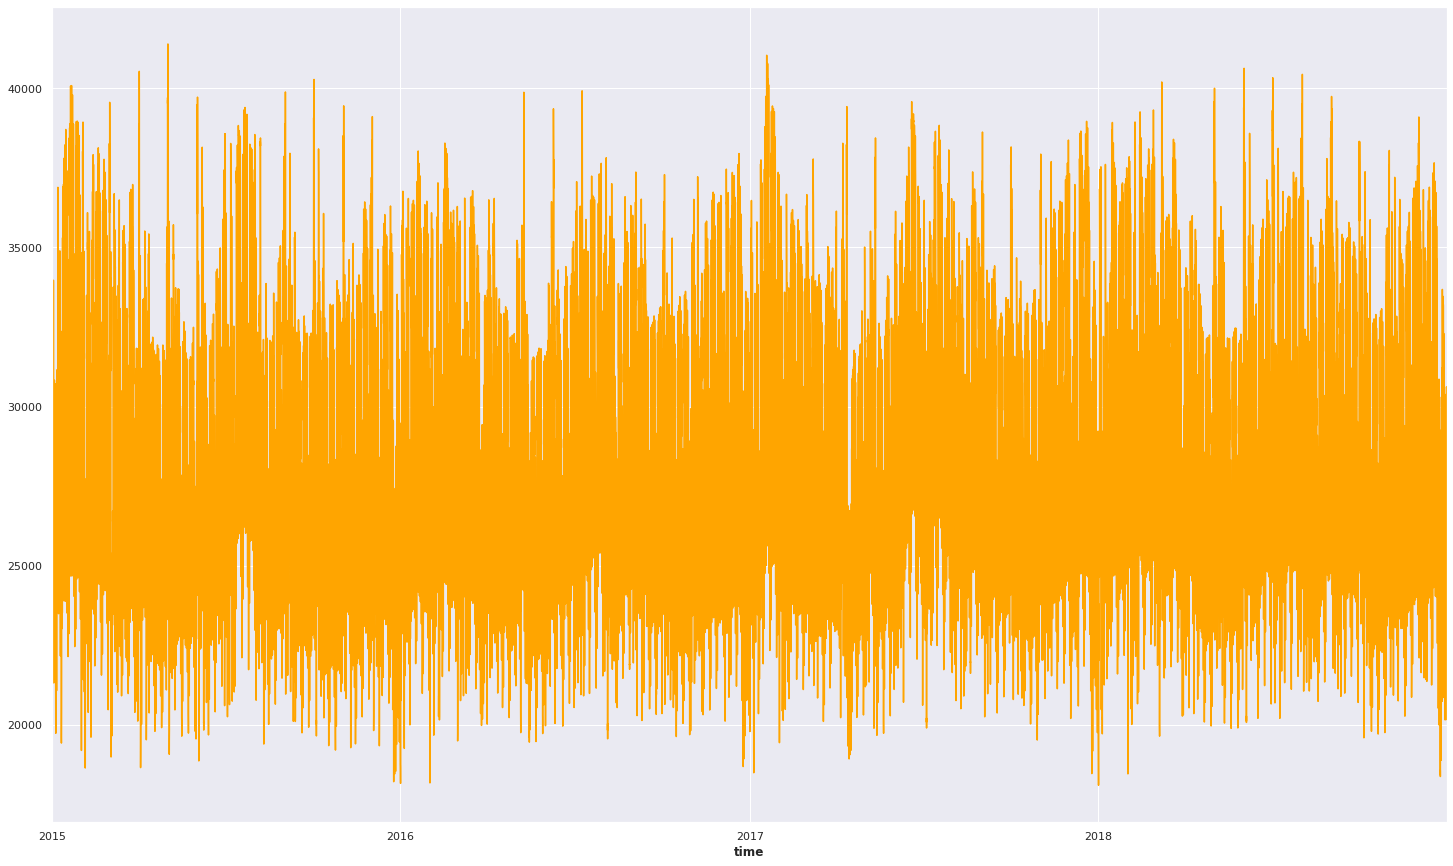

In [323]:
df_energy['total load forecast'].plot(color='orange')

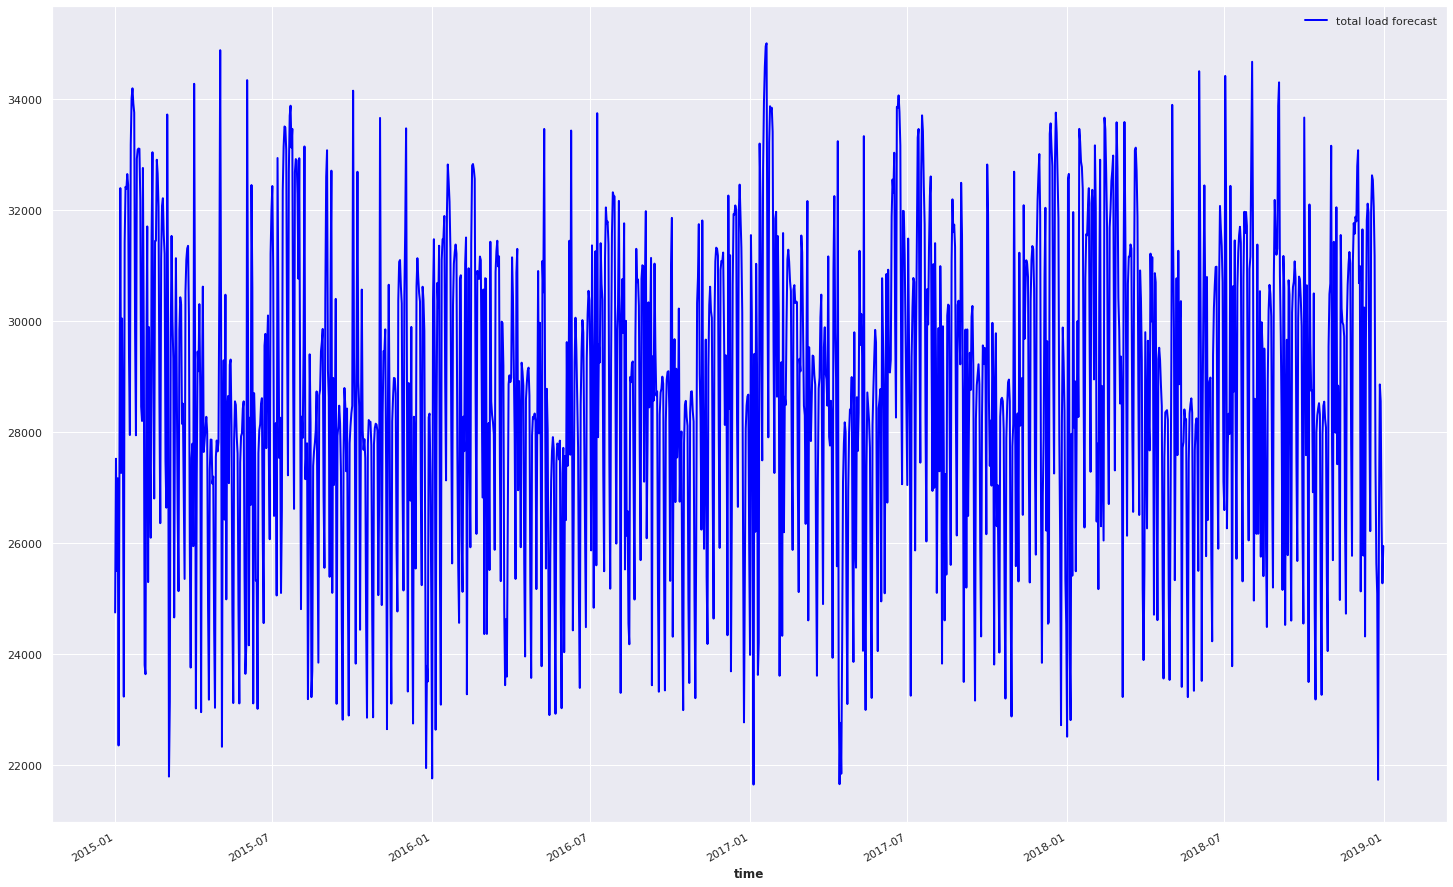

In [324]:
energy_ts.plot(color='blue')

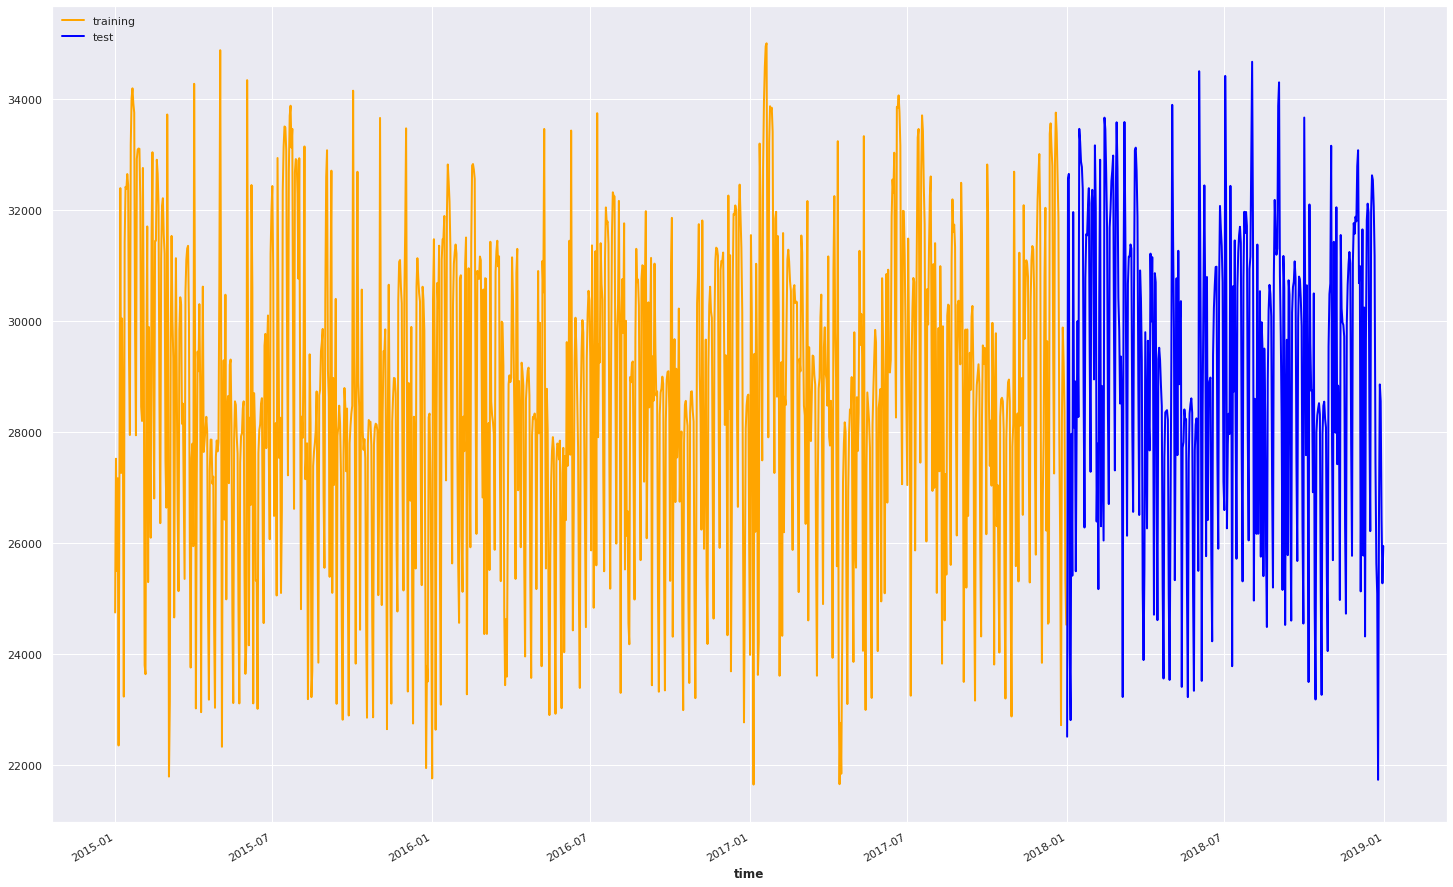

In [325]:
train, test = energy_ts.split_before(pd.Timestamp('20180101'))
train.plot(label='training', color='orange')
test.plot(label='test', color='blue')
plt.legend(loc=2);

# Check for seasonality - none evident so some of the seasonal models will not produce great results

In [227]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(energy_ts, m=m, alpha=.05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))
    else:         
        print('not seasonal')  
        break;


[2022-02-07 14:01:21,849] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


not seasonal


In [229]:
import torch

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


In [419]:
scaler_energy = Scaler()
energy_ts_scaled = scaler_energy.fit_transform(energy_ts)

In [420]:
train_energy, test_energy = energy_ts_scaled.split_before(pd.Timestamp('20180101'))

In [421]:
model_energy = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12,
    num_stacks=2,
    num_blocks=1, 
    num_layers=2, 
    layer_widths=32,
    n_epochs=200, 
    random_state=42,
    batch_size=24
)

In [422]:
model_energy.fit(train_energy, verbose=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [423]:
pred = model_energy.predict(n=len(test), series= train_energy)

MAPE = 62.91%


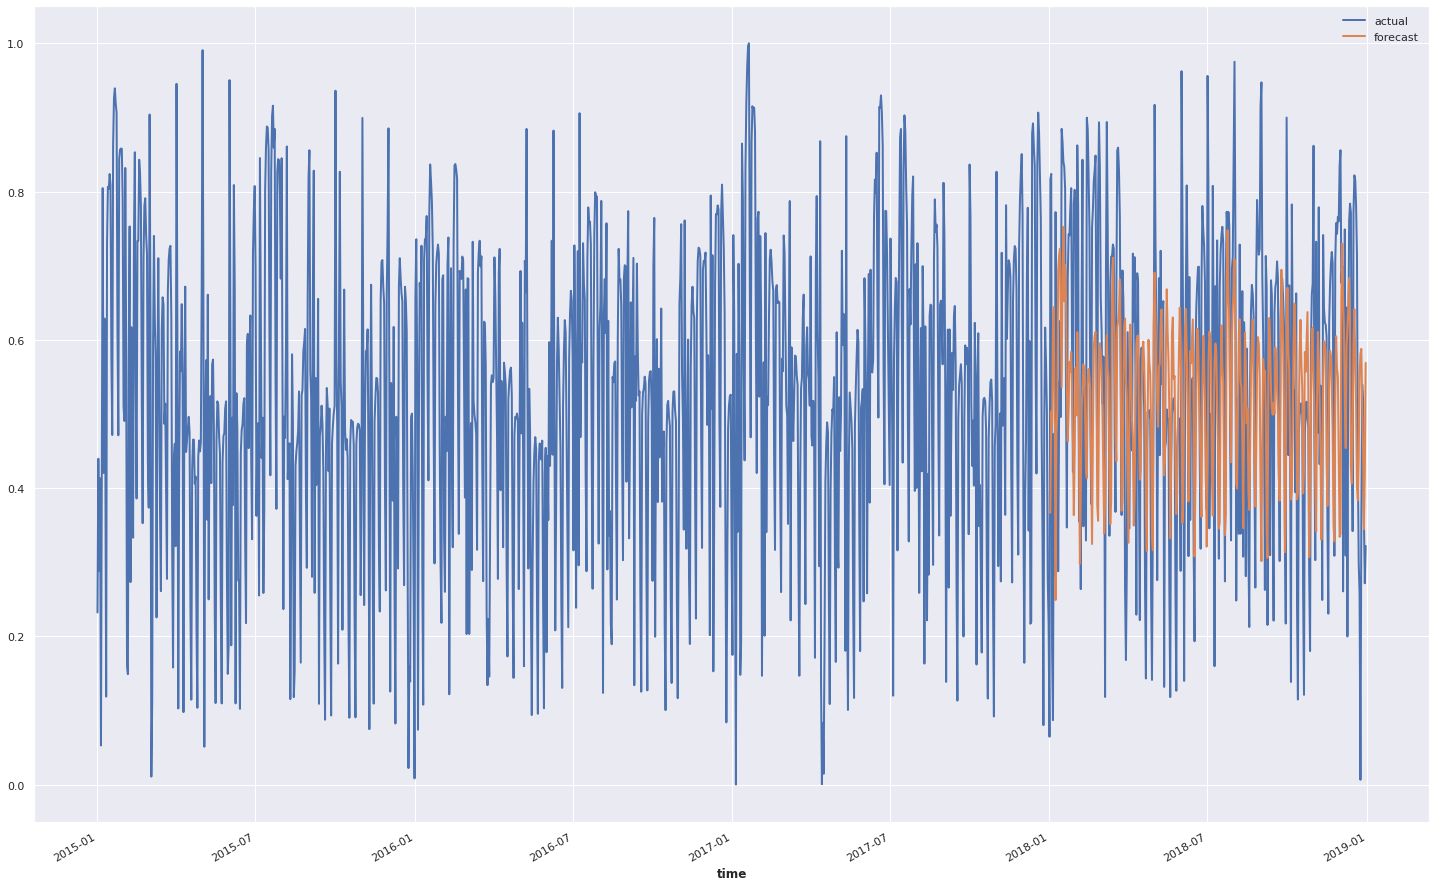

In [424]:
#energy_ts_scaled
energy_ts_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(energy_ts_scaled, pred)))

In [ ]:
******************************************************************************************8
*****************************************************************************8
*************************************************************************************88
from https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=299139c04786c3c68f39872b78bc5716df45ee37&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f756e697438636f2f64617274732f323939313339633034373836633363363866333938373262373862633537313664663435656533372f6578616d706c65732f30312d64617274732d696e74726f2e6970796e62&logged_in=false&nwo=unit8co%2Fdarts&path=examples%2F01-darts-intro.ipynb&platform=android&repository_id=148657183&repository_type=Repository&version=96

In [235]:
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [239]:
def eval_model(model):
    # fit the model on the training dataset
    model.fit(train)
    # model prediction on the test set
    pred = model.predict(len(test))
    print('model {} obtains MAPE: {:.1f}%'.format(model, mape(test, pred)))

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta(theta =  -0.04081632653061362)) # see below for theta calculation
#eval_model(RegressionEnsembleModel())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=24 obtains MAPE: 116.3%
model Prophet obtains MAPE: 7.6%
model Auto-ARIMA obtains MAPE: 19.6%
model Theta(-0.04081632653061362) obtains MAPE: 9.6%


# Theta model runs quickly so we can tune for the best results

In [240]:
# Search for the best theta parameter
thetas = 2 - np.linspace(-20, 20, 50)

best_mape = float('inf')
best_theta = 0.001

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(test))
    res = mape(test, pred_theta)
    
    if res < best_mape:
        best_mape = res
        best_theta = theta

best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(test))

print('The MAPE is: {:.2f}%, with theta = {}.'.format(mape(test, pred_best_theta), best_theta))

The MAPE is: 9.56%, with theta = -0.04081632653061362.


In [166]:
# from hcrystalball.ensemble import SimpleEnsemble
# from hcrystalball.wrappers import (
#     ExponentialSmoothingWrapper,
#     SarimaxWrapper,
#     get_sklearn_wrapper,
# )
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import ElasticNet

# from sktime.forecasting.hcrystalball import HCrystalBallForecaster

In [167]:
# models = {
#     "sarimax": SarimaxWrapper(init_with_autoarima=True, autoarima_dict={"m": 12}),
#     "smoothing": ExponentialSmoothingWrapper(
#         trend="add", seasonal="multiplicative", seasonal_periods=12
#     ),
#     "sklearn_linear": get_sklearn_wrapper(ElasticNet),
#     "sklearn_forest": get_sklearn_wrapper(RandomForestRegressor, n_estimators=100),
#     "avg_ensemble": SimpleEnsemble(
#         base_learners=[
#             get_sklearn_wrapper(ElasticNet, name="sklearn_linear"),
#             ExponentialSmoothingWrapper(
#                 trend="add",
#                 seasonal="multiplicative",
#                 seasonal_periods=12,
#                 name="smoothing",
#             ),
#         ],
#         ensemble_func="mean",
#     ),
# }


In [ ]:
# for model_name, model in models.items():
#     forecaster = HCrystalBallForecaster(model)
#     # if provided in the data, exogenous variables are supported over X_train, X_pred
    
#     forecaster.fit(y_train.to_timestamp())
#     fh = np.arange(1, len(y_test) +1)  # forecasting horizon
#     y_pred = forecaster.predict(fh)
#     smape_loss = mean_absolute_percentage_error(y_pred, y_test)
#     plot_series(
#         y_train,
#         y_test,
#         y_pred,
#         labels=[
#             "y_train",
#             "y_test",
#             f"y_pred_{model_name}[smape_loss:{smape_loss:.3}]",
#         ],
#     )

# To model the timeseries as multivariate it becomes necessary to join the weather and energy datasets and look for some correlations.

In [129]:
# 2. plot of temperature versus total load - 
#df_joined = pd.merge(df_weather,df_energy, how="inner", left_on =df_weather.index, right_on =df_energy.index)

df_joined = df_weather.join(df_energy)

In [130]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 167704 entries, 2015-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 33 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   city_name                                    167704 non-null  object 
 1   pressure                                     167704 non-null  int64  
 2   humidity                                     167704 non-null  int64  
 3   wind_speed                                   167704 non-null  int64  
 4   wind_deg                                     167704 non-null  int64  
 5   rain_1h                                      167704 non-null  float64
 6   snow_3h                                      167704 non-null  float64
 7   clouds_all                                   167704 non-null  int64  
 8   weather_main                                 167704 non-null  object 
 9   temp_C       

In [131]:
df_joined.head(10)

city_name  pressure  humidity  wind_speed  \
2015-01-01 00:00:00+00:00    Valencia      1001        77           1   
2015-01-01 00:00:00+00:00      Madrid       971        63           1   
2015-01-01 00:00:00+00:00      Bilbao      1035        97           0   
2015-01-01 00:00:00+00:00   Barcelona      1035       100           7   
2015-01-01 00:00:00+00:00     Seville      1039        75           1   
2015-01-01 01:00:00+00:00    Valencia      1002        78           0   
2015-01-01 01:00:00+00:00      Madrid       971        64           1   
2015-01-01 01:00:00+00:00      Bilbao      1036        97           1   
2015-01-01 01:00:00+00:00   Barcelona      1036       100           7   
2015-01-01 01:00:00+00:00     Seville      1039        71           3   

                           wind_deg  rain_1h  snow_3h  clouds_all  \
2015-01-01 00:00:00+00:00        62      0.0      0.0           0   
2015-01-01 00:00:00+00:00       309      0.0      0.0           0   
2015-01-01 00:00:00+00:00       229      0.0      0.0           0   
2015-01-01 00:00:00+00:00        58      0.0      0.0           0   
2015-01-01 00:00:00+00:00        21      0.0      0.0           0   
2015-01-01 01:00:00+00:00        23      0.0      0.0           0   
2015-01-01 01:00:00+00:00       273      0.0      0.0           0   
2015-01-01 01:00:00+00:00       224      0.0      0.0           0   
2015-01-01 01:00:00+00:00        48      0.0      0.0           0   
2015-01-01 01:00:00+00:00        27      0.0      0.0           0   

                          weather_main  temp_C  ...  generation solar  \
2015-01-01 00:00:00+00:00        clear    -2.7  ...              50.0   
2015-01-01 00:00:00+00:00        clear    -5.8  ...              50.0   
2015-01-01 00:00:00+00:00        clear    -3.4  ...              50.0   
2015-01-01 00:00:00+00:00        clear     8.5  ...              50.0   
2015-01-01 00:00:00+00:00        clear     0.2  ...              50.0   
2015-01-01 01:00:00+00:00        clear    -3.5  ...              50.0   
2015-01-01 01:00:00+00:00        clear    -7.0  ...              50.0   
2015-01-01 01:00:00+00:00        clear    -3.9  ...              50.0   
2015-01-01 01:00:00+00:00        clear     8.1  ...              50.0   
2015-01-01 01:00:00+00:00        clear     0.9  ...              50.0   

                           generation waste  generation wind onshore  \
2015-01-01 00:00:00+00:00             195.0                   5890.0   
2015-01-01 00:00:00+00:00             195.0                   5890.0   
2015-01-01 00:00:00+00:00             195.0                   5890.0   
2015-01-01 00:00:00+00:00             195.0                   5890.0   
2015-01-01 00:00:00+00:00             195.0                   5890.0   
2015-01-01 01:00:00+00:00             196.0                   5461.0   
2015-01-01 01:00:00+00:00             196.0                   5461.0   
2015-01-01 01:00:00+00:00             196.0                   5461.0   
2015-01-01 01:00:00+00:00             196.0                   5461.0   
2015-01-01 01:00:00+00:00             196.0                   5461.0   

                           forecast solar day ahead  \
2015-01-01 00:00:00+00:00                      16.0   
2015-01-01 00:00:00+00:00                      16.0   
2015-01-01 00:00:00+00:00                      16.0   
2015-01-01 00:00:00+00:00                      16.0   
2015-01-01 00:00:00+00:00                      16.0   
2015-01-01 01:00:00+00:00                       8.0   
2015-01-01 01:00:00+00:00                       8.0   
2015-01-01 01:00:00+00:00                       8.0   
2015-01-01 01:00:00+00:00                       8.0   
2015-01-01 01:00:00+00:00                       8.0   

                           forecast wind onshore day ahead  \
2015-01-01 00:00:00+00:00                           5856.0   
2015-01-01 00:00:00+00:00                           5856.0   
2015-01-01 00:00:00+00:00                           5856.0   
2015-01-01 00

In [132]:
df_joined.isna().sum()

city_name                                      0
pressure                                       0
humidity                                       0
wind_speed                                     0
wind_deg                                       0
rain_1h                                        0
snow_3h                                        0
clouds_all                                     0
weather_main                                   0
temp_C                                         0
temp_C_max                                     0
temp_C_min                                     0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear  

# Creating a correlation matrix and displaying it shows a few interesting things. Namely the temperature only has a 17% correlation with the total load actual. Two graphs shown - one for all correlations and then one with absolute values for correlations greater than 45%, lastly the specific correlations can be viewed in a list (select the field manually).

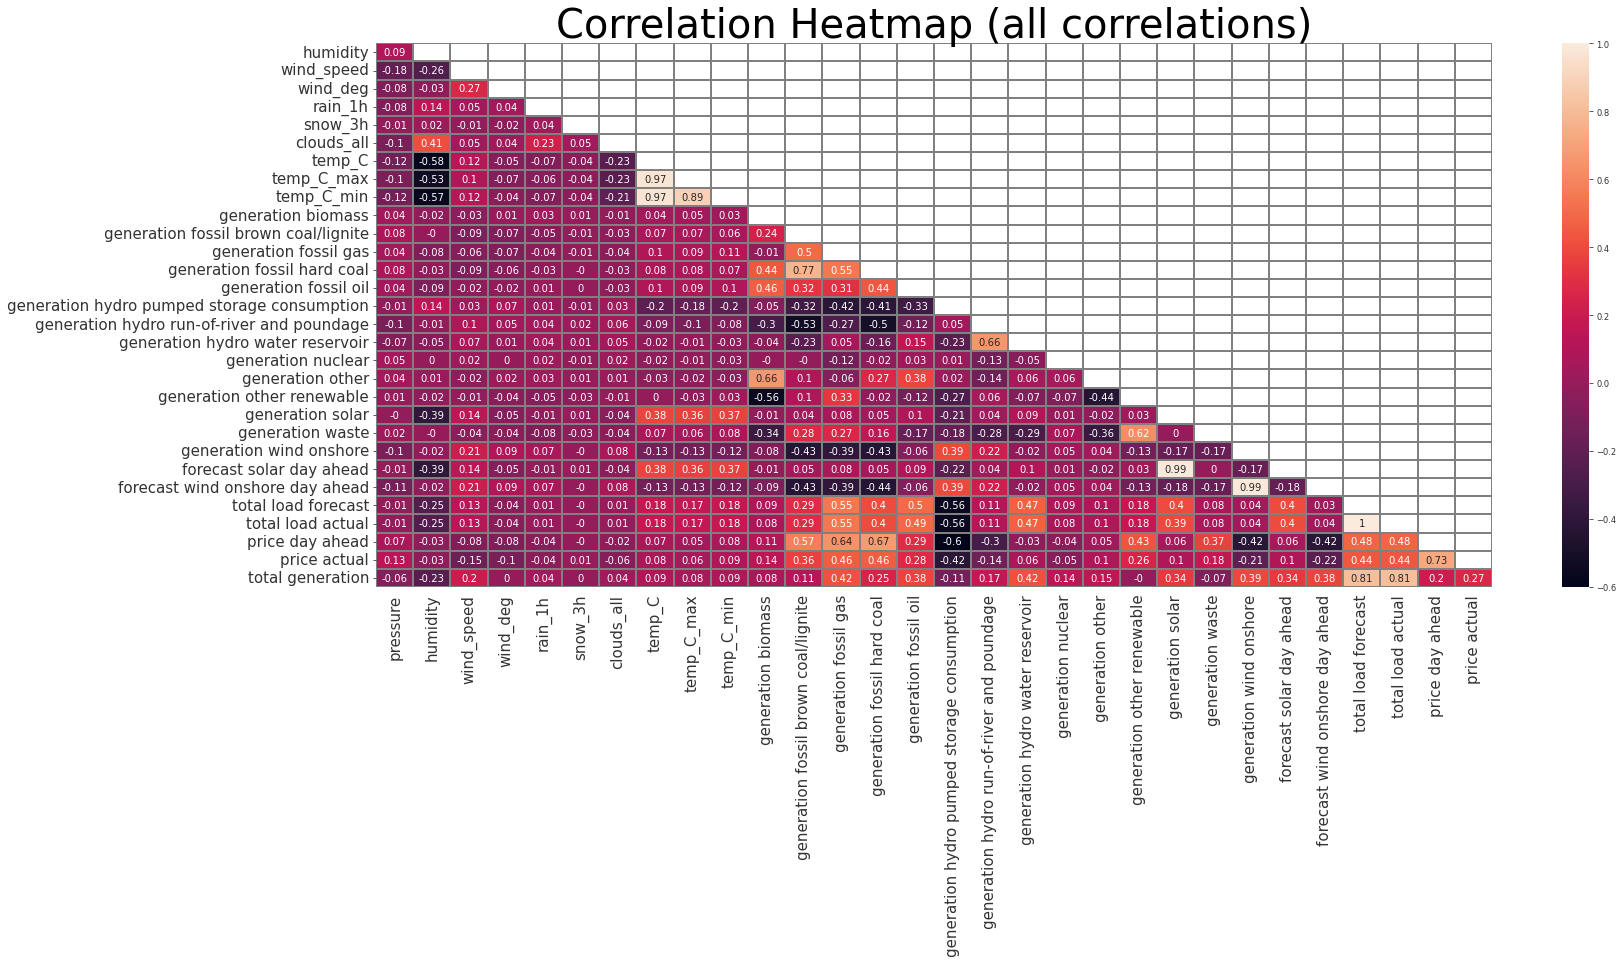

In [290]:
# To find the correlation among the columns using pearson method 

corr_matrix = df_joined.corr().round(2) # add in .abs() if not worried about positive or negative correlation just the strength


# use this to show only lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cut_off = -1 # to show all correlations

mask |= np.abs(corr_matrix) < cut_off
corr = corr_matrix[~mask]  # fill in NaN in the non-desired cells
# reove empty rows/columns to make it easier to read.
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]
# display the correlation value in a grid to make it easier to read.
s = sns.heatmap(corr,annot=True,  linewidths=0.1, linecolor='gray')
# increase the size of the labels.
s.set_title('Correlation Heatmap (all correlations)', fontsize=40)
s.set_xticklabels(s.get_xmajorticklabels(), fontsize = 15)
s.set_yticklabels(s.get_ymajorticklabels(), fontsize = 15)
plt.show()

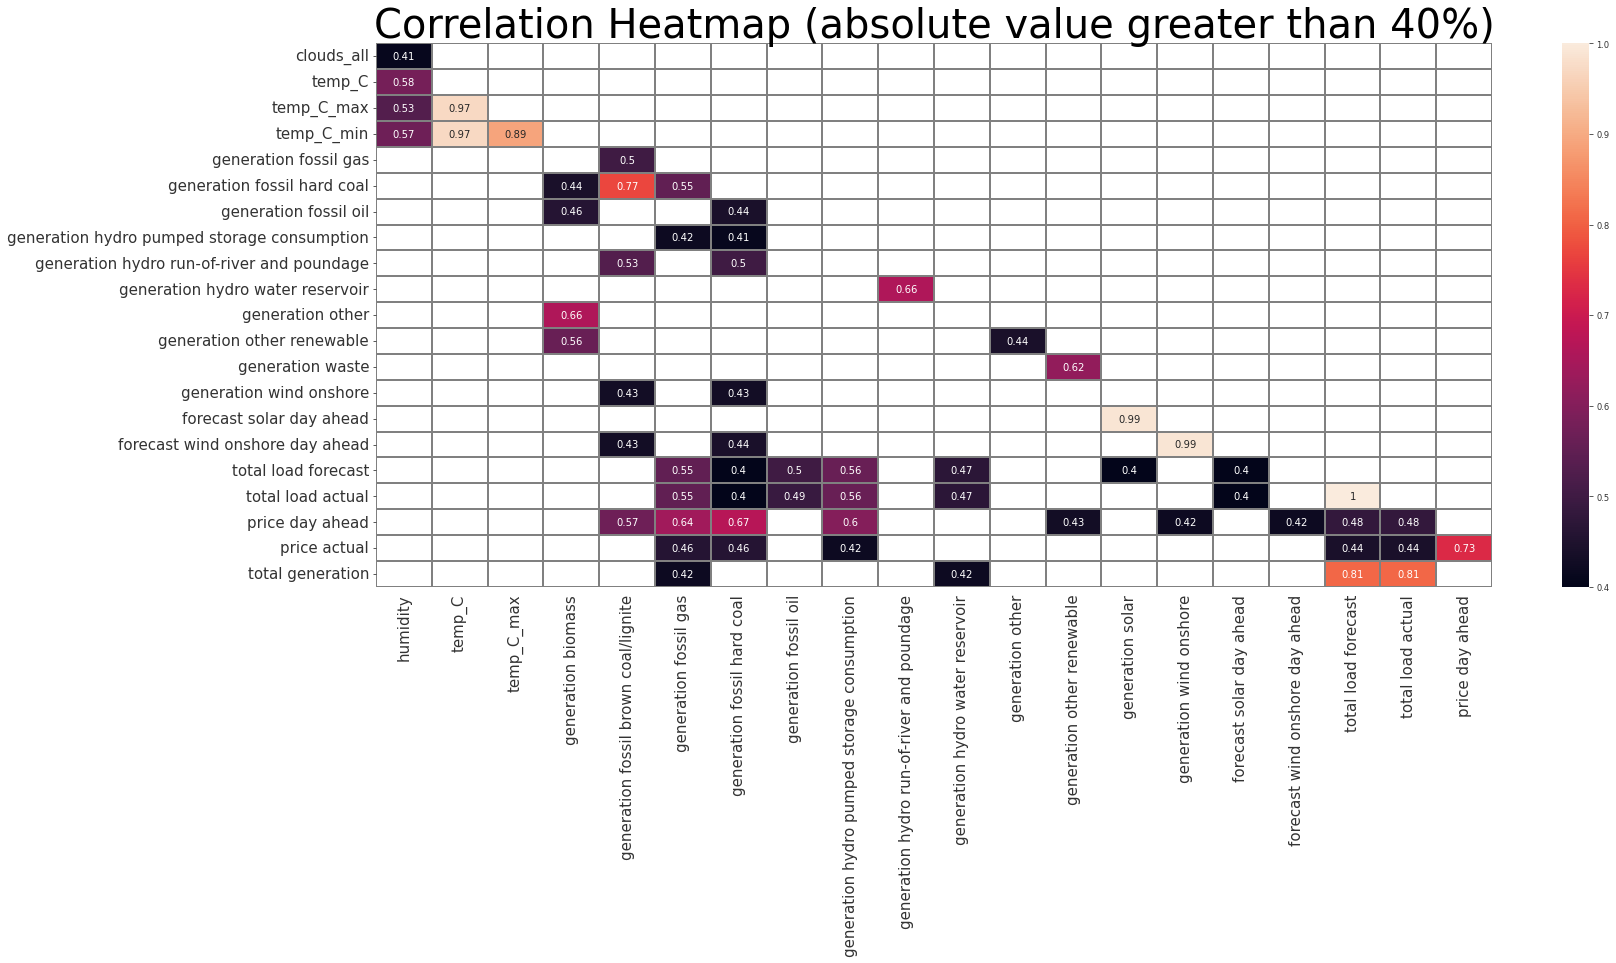

In [291]:
# To find the correlation among the columns using pearson method and then only display values with correlations > 45%

corr_matrix = df_joined.corr().abs().round(2) # add in .abs() if not worried about positive or negative correlation just the strength


# use this to show only lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cut_off = 0.40 # just show correlation greater than 40% 

mask |= np.abs(corr_matrix) < cut_off
corr = corr_matrix[~mask]  # fill in NaN in the non-desired cells
# reove empty rows/columns to make it easier to read.
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]
# display the correlation value in a grid to make it easier to read.
s = sns.heatmap(corr,annot=True,  linewidths=0.1, linecolor='gray')
# increase the size of the labels.
s.set_title('Correlation Heatmap (absolute value greater than 40%)', fontsize=40)
s.set_xticklabels(s.get_xmajorticklabels(), fontsize = 15)
s.set_yticklabels(s.get_ymajorticklabels(), fontsize = 15)
plt.show()

# Another way of viewing the correlations - this list can be changed to see different specific correlations - just change the specified field in the last line.

In [292]:
# way of viewing specific correlations
correlations = df_joined.corr().unstack().sort_values(ascending=False).drop_duplicates().round(2)
correlations['total load actual']  # change the required field here to get the specific correlations

generation fossil gas                   0.55
price day ahead                         0.48
generation fossil hard coal             0.40
generation solar                        0.39
generation fossil brown coal/lignite    0.29
temp_C_max                              0.17
wind_speed                              0.13
generation biomass                      0.08
generation nuclear                      0.08
clouds_all                              0.01
snow_3h                                -0.00
humidity                               -0.25
dtype: float64

In [293]:
correlations['temp_C']  # change the required field here to get the specific correlations

temp_C_max                          0.97
generation solar                    0.38
total load actual                   0.18
wind_speed                          0.12
generation fossil hard coal         0.08
price actual                        0.08
generation waste                    0.07
price day ahead                     0.07
generation other renewable          0.00
generation nuclear                 -0.02
generation hydro water reservoir   -0.02
pressure                           -0.12
generation wind onshore            -0.13
forecast wind onshore day ahead    -0.13
clouds_all                         -0.23
humidity                           -0.58
dtype: float64

# Since we are trying to predict the total load forecast value, the values correlated to that need to be included as predictors - from below we can see that the values to use are : 
## 'forecast solar day ahead', 'generation solar', 'generation fossil brown coal/lignite','temp_C', 'generation hydro run-of-river and poundage', 'generation waste','forecast wind onshore day ahead', 'wind_deg', 'humidity'

In [294]:
correlations['total load forecast']

total load actual                             1.00
forecast solar day ahead                      0.40
generation solar                              0.40
generation fossil brown coal/lignite          0.29
temp_C                                        0.18
generation hydro run-of-river and poundage    0.11
generation waste                              0.08
forecast wind onshore day ahead               0.03
wind_deg                                     -0.04
humidity                                     -0.25
dtype: float64

# So the target variable is the total load forecast and the predictors are as above. Now to see if a multivariate model can be trained using this data (and whether it is more accurate that simple training on the total load forecast - first make a smaller dataframe with the variables needed, then set up y_train/test and X_train/test

In [261]:
df_joined_pred = df_joined[['total load forecast','forecast solar day ahead', 'generation solar', 'generation fossil brown coal/lignite','temp_C', 'generation hydro run-of-river and poundage', 'generation waste','forecast wind onshore day ahead', 'wind_deg', 'humidity']]
df_joined_pred

total load forecast  forecast solar day ahead  \
2015-01-01 00:00:00+00:00              24934.0                      16.0   
2015-01-01 00:00:00+00:00              24934.0                      16.0   
2015-01-01 00:00:00+00:00              24934.0                      16.0   
2015-01-01 00:00:00+00:00              24934.0                      16.0   
2015-01-01 00:00:00+00:00              24934.0                      16.0   
...                                        ...                       ...   
2018-12-31 21:00:00+00:00              25450.0                      29.0   
2018-12-31 22:00:00+00:00              24424.0                      26.0   
2018-12-31 22:00:00+00:00              24424.0                      26.0   
2018-12-31 22:00:00+00:00              24424.0                      26.0   
2018-12-31 22:00:00+00:00              24424.0                      26.0   

                           generation solar  \
2015-01-01 00:00:00+00:00              50.0   
2015-01-01 00:00:00+00:00              50.0   
2015-01-01 00:00:00+00:00              50.0   
2015-01-01 00:00:00+00:00              50.0   
2015-01-01 00:00:00+00:00              50.0   
...                                     ...   
2018-12-31 21:00:00+00:00              31.0   
2018-12-31 22:00:00+00:00              31.0   
2018-12-31 22:00:00+00:00              31.0   
2018-12-31 22:00:00+00:00              31.0   
2018-12-31 22:00:00+00:00              31.0   

                           generation fossil brown coal/lignite  temp_C  \
2015-01-01 00:00:00+00:00                                 328.0    -2.7   
2015-01-01 00:00:00+00:00                                 328.0    -5.8   
2015-01-01 00:00:00+00:00                                 328.0    -3.4   
2015-01-01 00:00:00+00:00                                 328.0     8.5   
2015-01-01 00:00:00+00:00                                 328.0     0.2   
...                                                         ...     ...   
2018-12-31 21:00:00+00:00                                   0.0    11.0   
2018-12-31 22:00:00+00:00                                   0.0     6.0   
2018-12-31 22:00:00+00:00                                   0.0     2.5   
2018-12-31 22:00:00+00:00                                   0.0     7.0   
2018-12-31 22:00:00+00:00                                   0.0    10.8   

                           generation hydro run-of-river and poundage  \
2015-01-01 00:00:00+00:00                                      1009.0   
2015-01-01 00:00:00+00:00                                      1009.0   
2015-01-01 00:00:00+00:00                                      1009.0   
2015-01-01 00:00:00+00:00                                      1009.0   
2015-01-01 00:00:00+00:00                                      1009.0   
...                                                               ...   
2018-12-31 21:00:00+00:00                                      1128.0   
2018-12-31 22:00:00+00:00                                      1069.0   
2018-12-31 22:00:00+00:00                                      1069.0   
2018-12-31 22:00:00+00:00                                      1069.0   
2018-12-31 22:00:00+00:00                                      1069.0   

                           generation waste  forecast wind onshore day ahead  \
2015-01-01 00:00:00+00:00             195.0                           5856.0   
2015-01-01 00:00:00+00:00             195.0                           5856.0   
2015-01-01 00:00:00+00:00             195.0                           5856.0   
2015-01-01 00:00:00+00:00             195.0                           5856.0   
2015-01-01 00:00:00+00:00             195.0                           5856.0   
...                                     ...                              ...   
2018-12-31 21:00:00+00:00             287.0                           3273.0   
2018-12-31 22:00:00+00:00             287.0                           3117.0   
2018-12-31 22:00:00+00:00             287.0        

In [306]:
# Create the X_train, X_test, y_train, y_test datsets
X_train, X_test = df_joined_pred.loc[:,df_joined_pred.columns!='total load forecast']['2015-01-01':'2017-12-31'], df_joined_pred.loc[:,df_joined_pred.columns!='total load forecast']['2018-01-01':'2018-12-31']
y_train, y_test = df_joined_pred[['total load forecast']]['2015-01-01':'2017-12-31'], df_joined_pred[['total load forecast']]['2018-01-01':'2018-12-31']


In [307]:
print('y Train Dataset:',y_train.shape)
print('y Test Dataset:',y_test.shape)
print('x Train Dataset:',X_train.shape)
print('x Test Dataset:',X_test.shape)

y Train Dataset: (123519, 1)
y Test Dataset: (44185, 1)
x Train Dataset: (123519, 9)
x Test Dataset: (44185, 9)


In [308]:
y_train.head()

total load forecast
2015-01-01 00:00:00+00:00              24934.0
2015-01-01 00:00:00+00:00              24934.0
2015-01-01 00:00:00+00:00              24934.0
2015-01-01 00:00:00+00:00              24934.0
2015-01-01 00:00:00+00:00              24934.0

In [ ]:

net architecture RNN LSTMs === look into other ways of doing



https://towardsdatascience.com/temporal-fusion-transformer-googles-model-for-interpretable-time-series-forecasting-5aa17beb621

 
set shuffle=False in test/train split in sklearn.  and lstm model

In [ ]:
 DARTS LIBRARY DARTS LIBRARY DARTS LIBRARY DARTS LIBRARY
    
    
    DARTS LIBRARY - also SARIMA
    
    DARTS LIBRARY
    https://www.youtube.com/watch?v=cKJKHGlbSi4 - using the energy dataset
    https://medium.com/unit8-machine-learning-publication/darts-time-series-made-easy-in-python-5ac2947a8878
    DARTS LIBRARY

In [ ]:
########################@#$^&#%^*$*$^&%*$&^*$^&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$@!#$^@%$#################################################################################################################$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$^%&@$%@%%%%%%%%%%%%%%%%%%%%%%%%
#####################################################################################################################################################################33
###########################################
###########################################                       THE END THE END THE END THE END THE END THE END
###########################################
##########################################################################################################################################################################################
####################################################################################################################################################################################################

In [ ]:
###################################################
#$%^@$%^&@#^&#&^%*($^&(%&)%)^%)^%()^%*()^*()^*()^*()^*()^*&()^(*^)^&*()^%&(*)^%()^%(*)^%()^*()^*()^*()^(*)(%&*(%&*(%&*(%))))



# https://towardsdatascience.com/why-start-using-sktime-for-forecasting-8d6881c0a518







In [ ]:








# https://ai.plainenglish.io/time-series-forecasting-with-sktime-in-python-3dfaf55e1a9c










# take mean of all temperatures for all cities and compare against energy usage in a plot













In [309]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA
from sktime.utils.plotting import plot_series
import seaborn as sns
sns.set(rc={'figure.figsize':(25,15)})

y = df_energy[['total load forecast']]  #.resample('D').mean()
#y_train, y_test = temporal_train_test_split(y, test_size=12)
y_train = y[y.index.year!=2018] # train on years 2015, 2016, 2017
y_test = y[y.index.year==2018] # test of year 2018


fh_abs = ForecastingHorizon(y_test.index, is_relative=False) 
#fh described abovfe
forecaster = AutoARIMA(sp=365*24)  # throws and warnig for not enough season - ARIMA needs 5 season and have only 3 to train on if monthly resampling is used. 
# Daily resampling is better but takes a long time - Hourly is what we are given
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_abs)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

KeyboardInterrupt: 

In [ ]:
# Agreggate temperatures with city name and month of year
df2 = df_weather.groupby(['city_name',df_weather.index.month], as_index=True).agg(
    {
        'temp_C':['mean'],#,'min','max'],
        'temp_C_min':['mean'],
        'temp_C_max':['mean'],
        'humidity':['mean'],#,'min','max'],
    }
).round(1)


In [ ]:
df2.head()

In [ ]:
df2.plot.bar(figsize=(25,10)) 
#title("Mean Monthly temperatures and humidty for each City")

In [ ]:
df2.groupby('city_name').plot.bar(figsize=(10,7))


In [ ]:

df_weather.groupby('city_name').mean().round(1)

# Important things for renwable generation are wind speed and cloud cover - let's have a look at that now.

In [ ]:
# check how many na values for clouds
df_weather['clouds_all'].isna().sum()

In [ ]:
# a sample of some raows
df_weather[['city_name','clouds_all']][10006:10012]

In [ ]:
# check how many have 0 clouds
(df_weather['clouds_all']==0).sum()

# Viewing cloud data the visual density would seem to suggest Bilboa is the cloudiest and Madrid/Seville the least cloudy.

In [ ]:
df_joined.head(20)

In [ ]:


plt.figure(figsize=[30,10])
sns.boxplot(x=df_joined.index.hour, y='total load actual', data=df_joined)
#axes = df.groupby(df_energy.index.hour).plot(marker='.', alpha=0.5, linestyle='None', figsize=(25,10))#, subplots=True)
plt.ylabel('Load (GWh)',fontsize=20)
plt.xlabel('Hour',fontsize=20)
plt.title('Load by hour of day',fontsize=30)

In [ ]:
corr = df[['total load actual','temp_C_max','temp_C_min']].corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
df_joined.columns

# Darts’ Swiss Knife for Time Series Forecasting

## https://towardsdatascience.com/darts-swiss-knife-for-time-series-forecasting-in-python-f37bb74c126


# Some correlation graphs to see whether there are any correlations in the joined datframe. Surprisingly clouds_all has a small negative correlation with solar generation - this indicates that the solar generators are in the cities (which I guess isn't really that surprising).

In [ ]:
# Look for correlations in the newly joined energy and weather table and see if anything relates - big table so need to reduce to 
corr = df_joined.corr()
#corr_pairs = corr.unstack()
#sorted_pairs = corr_pairs.sort_values(kind="quicksort")
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
dfCorr = df_joined[['temp_C','generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'clouds_all','generation solar',
       'generation waste', 'generation wind onshore'    #,'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead','price actual'
       ]].corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

In [ ]:
dfCorr = df_joined[[ 'clouds_all','generation solar', 'forecast solar day ahead',  'price day ahead'
       ]].corr()
filteredDf = dfCorr[((dfCorr >= .01) | (dfCorr <= -.01)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="Blues")
plt.show()

In [ ]:
corr = df_joined[['generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual']].corr()

kot = corr[corr>=.4]
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Greens")

In [ ]:
df_joined.columns

In [ ]:
df_joined[['generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual']].groupby(df_joined.index.month).mean().plot(figsize=(25,10))

In [ ]:
df_joined[df_joined.index.duplicated()]

# Time series forecasting using sktime library.

In [ ]:
y[y.index.duplicated()]

In [ ]:
y.drop_duplicates(inplace=True)

In [ ]:
from sktime.forecasting.base import ForecastingHorizon
import pytz

madridtz = pytz.timezone('Europe/Madrid')

fh = ForecastingHorizon( 
    #fh.index = fh.index.tz_localize(pytz.utc).tz_convert(madridtz)
    
    pd.PeriodIndex(pd.date_range("2018-01-01"), periods=365, freq="D", is_relative=False)
)
fh

In [ ]:
y_train, y_test = temporal_train_test_split(y, train_size=0.7279)

In [ ]:
y_train.tail()

In [ ]:
# Training data is years 2015, 2016,2017 and test data is 2018.
y=df_energy['total load actual']
y_train = y[y.index.year!=2018]
y_test = y[y.index.year>=2018]


#y_train, y_test = temporal_train_test_split(y, train_size=0.7)
fig, axes = plt.subplots(1,1, figsize=(20, 10))
#ax.plot(y.values)
axes = y_train.plot(ax=axes, label='y_train')
axes = y_test.plot(ax=axes, label='y_test')
axes.legend(loc='upper right', frameon=False, fontsize=15)

axes.set_title('Test/train split', fontsize=40)
axes.set_ylabel('Price', fontsize=30)
axes.set_xlabel("Year", fontsize=20)

In [ ]:
y.index

In [ ]:
df_energy.index = pd.to_datetime(df_energy.index, utc='False')
df_energy.index = df_energy.index.tz_convert('Europe/Madrid')

In [ ]:
y_test   #.isna().sum()
y_train

In [ ]:
fh = ForecastingHorizon(y_train.index, is_relative=False)

In [ ]:
forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity

In [ ]:
forecaster.fit(y_train )

In [ ]:
y_pred = forecaster.predict(fh=365)

In [ ]:
smape_loss(y_test, y_pred) 

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.arima import AutoARIMA

#y = df['realgdp']
y_train, y_test = temporal_train_test_split(y, test_size=12) 

forecaster = MultiplexForecaster(
    forecasters=[
        ("theta", ThetaForecaster(sp=12)),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
        ("autoarima", AutoARIMA(sp=12)),
    ],
)
cv = SlidingWindowSplitter(initial_window=48, window_length=12)
forecaster_param_grid = {"selected_forecaster": [ "autoarima"]}  #"theta", "ets",
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)
#forecaster.fit(y_train)
gscv.fit(y_train)
#print(gscv.best_params_)